In [1]:
import os
import glob

import numpy as np
import scipy.stats
import pandas as pd
import pytz
import xarray as xr

import act
from sublimpy import utils
from sublimpy import tidy

import matplotlib.pyplot as plt
import altair as alt
alt.data_transformers.enable('json')
alt.renderers.enable('jupyterlab')

import datetime as dt

* use script `analysis/sail/lidar_wind_profile_synoptic_wind_coherence.py` to download synoptic wind data
* use `cumulative_sublimation.ipynb` to create daily dataset
* use `analysis/sos/create_turbulence_dataset.ipynb` to create SoS tidy dataset and the (disdrometer) precip data

In [2]:
# Inputs
start_date = '20221130'
end_date = '20230509'
met_gothic = 'gucmetM1.b1'
tsi_sail_code = 'guctsiskycoverM1.b1'
data_dir = '/data2/elilouis/sublimationofsnow'
username = os.getenv("ARM_USERNAME")
token = os.getenv("ARM_TOKEN")

daily_tidy_dataset_fn = 'tidy_df_daily_20221130_20230509_noplanar_fit.parquet'

### Open Data 

#### SoS

In [3]:
try:
    tidy_df_30Min = pd.read_parquet(f"../sos/tidy_df_30Min_{start_date}_{end_date}_noplanar_fit.parquet")
except FileNotFoundError:
    print("No file such file exists for these dates.")

try:
    tidy_df_5Min = pd.read_parquet(f"../sos/tidy_df_{start_date}_{end_date}_noplanar_fit.parquet")
except FileNotFoundError:
    print("No file such file exists for these dates.")
    
tidy_df_5Min['time'] = pd.to_datetime(tidy_df_5Min['time'])
tidy_df_30Min['time'] = pd.to_datetime(tidy_df_30Min['time'])


tidy_df_daily = pd.read_parquet(daily_tidy_dataset_fn)

#### SoS Snowpit data

In [4]:
# Open our data files
ds_data = xr.open_dataset('../sos/snowpits/kettle_ponds_snowpit_profiles.nc')
# ds_layer = xr.open_dataset('./kettle_ponds_snowpit_layers.nc')
# ds_data.to_dataframe()[['density']].dropna().groupby('time').apply(lambda df: df['density'].iloc[-1]).plot(label = 'surface')
# ds_data.to_dataframe()[['density']].dropna().groupby('time').apply(lambda df: df['density'].iloc[-2]).plot(label = '-10cm')
# ds_data.to_dataframe()[['density']].dropna().groupby('time').apply(lambda df: df['density'].iloc[-3]).plot(label = '-20cm')

In [5]:
surface_density = ds_data.to_dataframe()[['density']].dropna().groupby('time').apply(lambda df: df['density'].iloc[-1])

#### Precip data

In [6]:
precip_df = pd.read_csv("../sos/disdro_daily_max_precip_date_df.csv")
precip_df['time'] = pd.to_datetime(precip_df['time'])

precip_5min_df = pd.read_parquet("../sos/precip_rate.parquet")
precip_5min_df = precip_5min_df.reset_index()
precip_5min_df['time'] = pd.to_datetime(precip_5min_df['time'])

#### SAIL TSI

In [7]:
sail_tsi_dir = os.path.join(data_dir, tsi_sail_code)

print("Downloading")
# act.discovery.download_data(
#     username,    token,    tsi_sail_code,    startdate=start_date,   enddate=end_date,
#     output = sail_tsi_dir
# )
print("Loading")
tsi_ds = act.io.armfiles.read_netcdf(
    glob.glob(os.path.join(sail_tsi_dir, '*.cdf'))
)

Downloading
Loading


#### SAIL Sonde

In [8]:
synoptic_winds_df = pd.read_parquet('../sail/synoptic_winds_500_local.parquet')
synoptic_winds_df = synoptic_winds_df.groupby("time").mean().reset_index()

#### SAIL Met

In [9]:
met_gothic_path = os.path.join(data_dir, met_gothic)

In [10]:
met_gothic_path = os.path.join(data_dir, met_gothic)

# act.discovery.download_data(
#     username, token, met_gothic, start_date, end_date,
#     output = met_gothic_path
# )

In [11]:
met_gothic_ds = act.io.armfiles.read_netcdf(glob.glob(os.path.join(met_gothic_path, '*.cdf')))

In [12]:
met_gothic_ds = utils.modify_xarray_timezone(met_gothic_ds, pytz.UTC, pytz.timezone('US/Mountain'))
met_gothic_ds = met_gothic_ds.sel(time=slice(start_date,end_date))

## Prep daily datasets and combine

In [13]:
tidy_df_daily_variables = pd.concat([
    tidy_df_daily.query("tower == 'd'").query("height == 3").query("variable == 'Cumulative sublimation (mm)'"),
    tidy_df_daily[tidy_df_daily.variable == 'Rsw_in_9m_d'],
    tidy_df_daily[tidy_df_daily.variable.isin(['SF_avg_1m_ue', 'SF_avg_2m_ue'])].groupby("time").max().reset_index()
])

tidy_df_daily_variables = tidy_df_daily_variables[['time', 'measurement', 'value']].pivot_table(values = 'value', index='time', columns=['measurement']).reset_index()

In [14]:
tsi_ds_daily = tsi_ds.resample(time='1440Min').mean()
tsi_daily_df = tsi_ds_daily[['sunny', 'percent_opaque']].to_dataframe().reset_index()
tsi_daily_df = utils.modify_df_timezone(tsi_daily_df, pytz.UTC, pytz.timezone("US/Mountain"))

In [15]:
synoptic_winds_daily_df = synoptic_winds_df.set_index('time').groupby(pd.Grouper(freq='1440Min')).mean().reset_index()

In [16]:
synoptic_winds_daily_df.time = synoptic_winds_daily_df.time.dt.date

In [17]:
tsi_daily_df.time = tsi_daily_df.time.dt.date

In [18]:
tidy_df_daily_variables.time = tidy_df_daily_variables.time.dt.date

In [19]:
daily_sos_and_synoptic_df = synoptic_winds_daily_df.merge(
    tsi_daily_df, on='time', how='inner'
).merge(
    tidy_df_daily_variables, on='time', how='inner'
)

# Plot

### Blowing snow v wind speed

(0.0, 1.0)

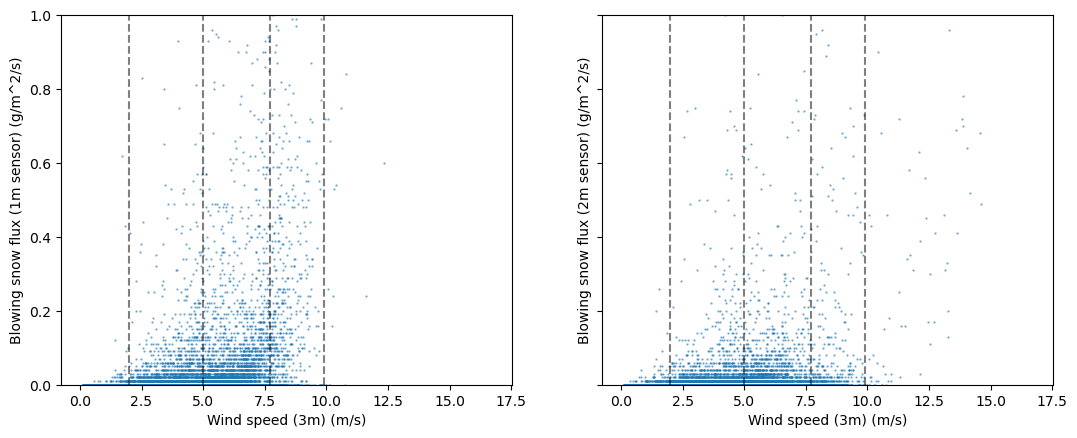

In [20]:

fig, axes = plt.subplots(1,2, figsize=(12.8, 4.8), sharey=True, sharex=True)
for ax in axes:
    for threshold in [2,5,7.7,9.9]:
        ax.axvline(threshold, color='k', linestyle='--', alpha=0.5)

axes[0].scatter(
    tidy_df_5Min.query("variable == 'spd_3m_c'").value,
    tidy_df_5Min.query("variable == 'SF_avg_1m_ue'").value,
    s=0.5,
    alpha=0.5
)
axes[1].scatter(
    tidy_df_5Min.query("variable == 'spd_3m_c'").value,
    tidy_df_5Min.query("variable == 'SF_avg_2m_ue'").value,
    s=0.5,
    alpha=0.5
)
axes[0].set_ylabel("Blowing snow flux (1m sensor) (g/m^2/s)")
axes[1].set_ylabel("Blowing snow flux (2m sensor) (g/m^2/s)")
axes[0].set_xlabel("Wind speed (3m) (m/s)")
axes[1].set_xlabel("Wind speed (3m) (m/s)")

plt.ylim(0,1)


Only looking at data 0-1 days after snowfall

(0.0, 1.0)

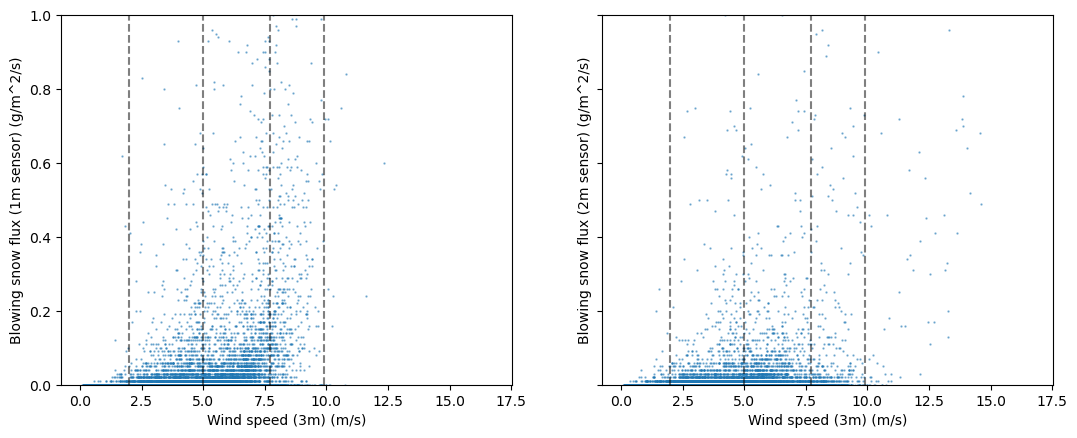

In [21]:
src = tidy_df_5Min[
    tidy_df_5Min.time.dt.date.isin(
        precip_df[precip_df['days_since_precip'] < 2]['time'].dt.date
    )
]

fig, axes = plt.subplots(1,2, figsize=(12.8, 4.8), sharey=True, sharex=True)
for ax in axes:
    for threshold in [2,5,7.7,9.9]:
        ax.axvline(threshold, color='k', linestyle='--', alpha=0.5)

axes[0].scatter(
    src.query("variable == 'spd_3m_c'").value,
    src.query("variable == 'SF_avg_1m_ue'").value,
    s=0.5,
    alpha=0.5
)
axes[1].scatter(
    src.query("variable == 'spd_3m_c'").value,
    src.query("variable == 'SF_avg_2m_ue'").value,
    s=0.5,
    alpha=0.5
)
axes[0].set_ylabel("Blowing snow flux (1m sensor) (g/m^2/s)")
axes[1].set_ylabel("Blowing snow flux (2m sensor) (g/m^2/s)")
axes[0].set_xlabel("Wind speed (3m) (m/s)")
axes[1].set_xlabel("Wind speed (3m) (m/s)")

plt.ylim(0,1)


With low snow surface densities:

Text(0.5, 0, 'Wind speed (3m) (m/s)')

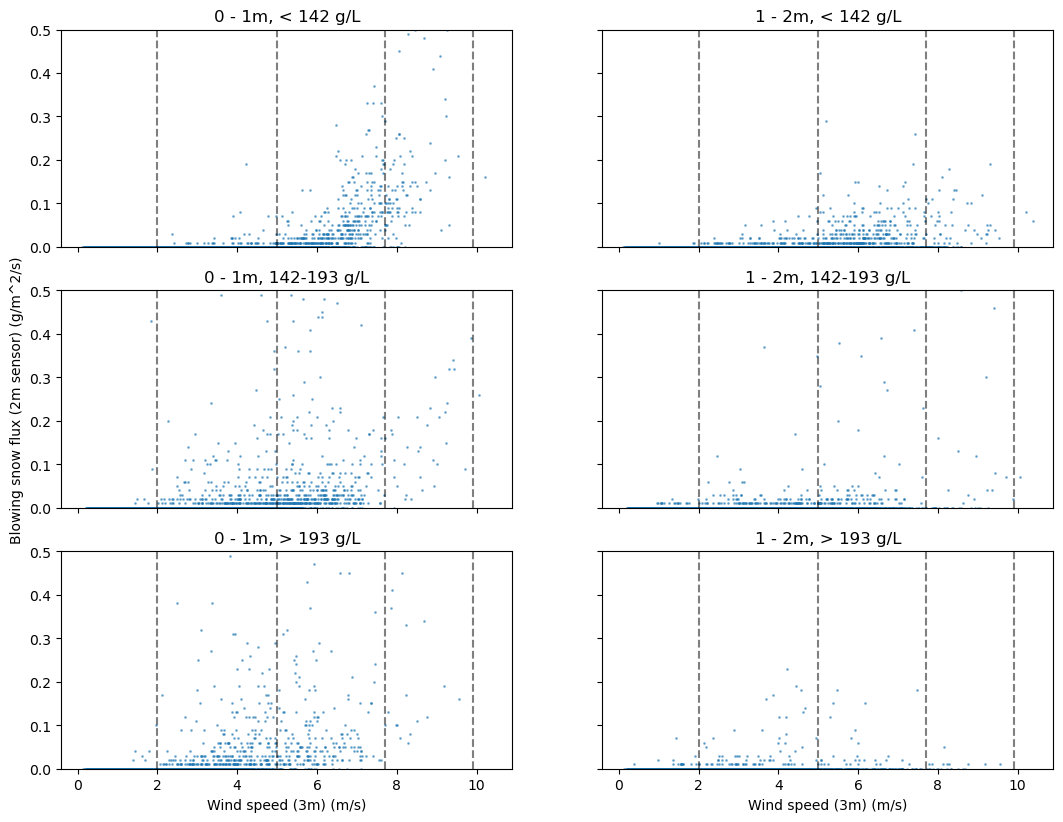

In [22]:
src_low = tidy_df_5Min[
    tidy_df_5Min.time.dt.date.isin(
        surface_density[surface_density < 142].index.date
    )
]
src_mid = tidy_df_5Min[
    tidy_df_5Min.time.dt.date.isin(
        surface_density[(surface_density >= 142) & (surface_density <= 193)].index.date
    )
]
src_high = tidy_df_5Min[
    tidy_df_5Min.time.dt.date.isin(
        surface_density[surface_density > 193].index.date
    )
]

fig, axes = plt.subplots(3,2, figsize=(12.8, 9.6), sharey=True, sharex=True)
for ax in axes.ravel():
    for threshold in [2,5,7.7,9.9]:
        ax.axvline(threshold, color='k', linestyle='--', alpha=0.5)
        ax.set_ylim(0,0.5)

axes[0,0].set_title("0 - 1m, < 142 g/L")
axes[0,0].scatter(
    src_low.query("variable == 'spd_3m_c'").value,
    src_low.query("variable == 'SF_avg_1m_ue'").value,
    s=1.0,
    alpha=0.5
)
axes[0,1].set_title("1 - 2m, < 142 g/L")
axes[0,1].scatter(
    src_low.query("variable == 'spd_3m_c'").value,
    src_low.query("variable == 'SF_avg_2m_ue'").value,
    s=1.0,
    alpha=0.5
)

axes[1,0].set_title("0 - 1m, 142-193 g/L")
axes[1,0].scatter(
    src_mid.query("variable == 'spd_3m_c'").value,
    src_mid.query("variable == 'SF_avg_1m_ue'").value,
    s=1.0,
    alpha=0.5
)
axes[1,1].set_title("1 - 2m, 142-193 g/L")
axes[1,1].scatter(
    src_mid.query("variable == 'spd_3m_c'").value,
    src_mid.query("variable == 'SF_avg_2m_ue'").value,
    s=1.0,
    alpha=0.5
)

axes[2, 0].set_title("0 - 1m, > 193 g/L")
axes[2, 0].scatter(
    src_high.query("variable == 'spd_3m_c'").value,
    src_high.query("variable == 'SF_avg_1m_ue'").value,
    s=1.0,
    alpha=0.5
)
axes[2, 1].set_title("1 - 2m, > 193 g/L")
axes[2, 1].scatter(
    src_high.query("variable == 'spd_3m_c'").value,
    src_high.query("variable == 'SF_avg_2m_ue'").value,
    s=1.0,
    alpha=0.5
)

axes[1, 0].set_ylabel("Blowing snow flux (2m sensor) (g/m^2/s)")
axes[2, 0].set_xlabel("Wind speed (3m) (m/s)")
axes[2, 1].set_xlabel("Wind speed (3m) (m/s)")

/tmp/ipykernel_84299/2242883318.py:25: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,1)


(0.006346872706983886, 1)

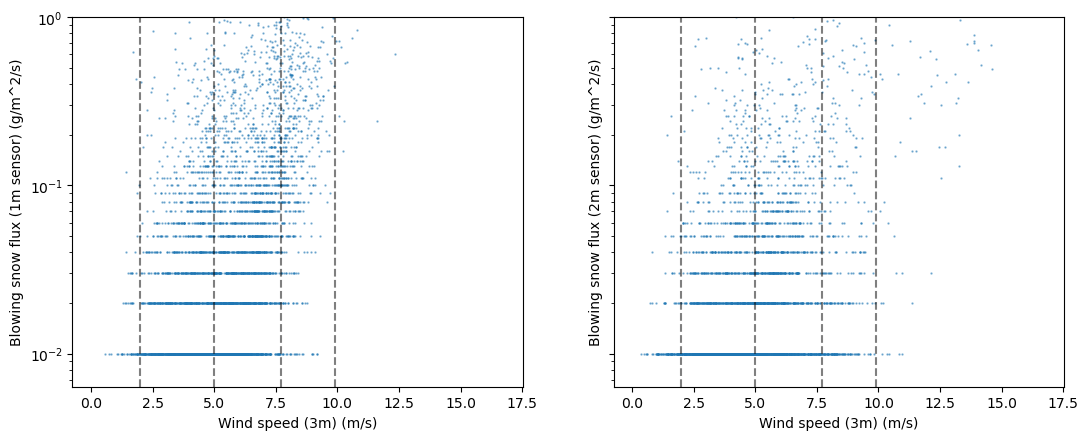

In [23]:
fig, axes = plt.subplots(1,2, figsize=(12.8, 4.8), sharey=True, sharex=True)
for ax in axes:
    for threshold in [2,5,7.7,9.9]:
        ax.axvline(threshold, color='k', linestyle='--', alpha=0.5)

axes[0].scatter(
    tidy_df_5Min.query("variable == 'spd_3m_c'").value,
    tidy_df_5Min.query("variable == 'SF_avg_1m_ue'").value,
    s=0.5,
    alpha=0.5
)
axes[1].scatter(
    tidy_df_5Min.query("variable == 'spd_3m_c'").value,
    tidy_df_5Min.query("variable == 'SF_avg_2m_ue'").value,
    s=0.5,
    alpha=0.5
)
axes[0].set_ylabel("Blowing snow flux (1m sensor) (g/m^2/s)")
axes[1].set_ylabel("Blowing snow flux (2m sensor) (g/m^2/s)")
axes[0].set_xlabel("Wind speed (3m) (m/s)")
axes[1].set_xlabel("Wind speed (3m) (m/s)")
axes[0].set_yscale('log')
axes[1].set_yscale('log')

plt.ylim(0,1)


### Blowing snow v shear velocity

(0.0, 1.0)

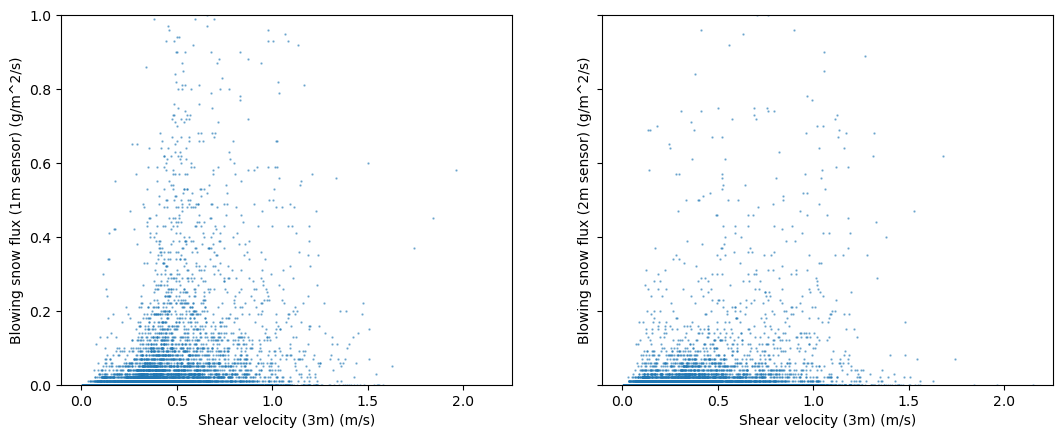

In [24]:
fig, axes = plt.subplots(1,2, figsize=(12.8, 4.8), sharey=True, sharex=True)

axes[0].scatter(
    tidy_df_5Min.query("variable == 'u*_3m_c'").value,
    tidy_df_5Min.query("variable == 'SF_avg_1m_ue'").value,
    s=0.5,
    alpha=0.5
)
axes[1].scatter(
    tidy_df_5Min.query("variable == 'u*_3m_c'").value,
    tidy_df_5Min.query("variable == 'SF_avg_2m_ue'").value,
    s=0.5,
    alpha=0.5
)
axes[0].set_ylabel("Blowing snow flux (1m sensor) (g/m^2/s)")
axes[1].set_ylabel("Blowing snow flux (2m sensor) (g/m^2/s)")
axes[0].set_xlabel("Shear velocity (3m) (m/s)")
axes[1].set_xlabel("Shear velocity (3m) (m/s)")

plt.ylim(0,1)

## Blowing snow v surface snow density (snowpit data)

In [25]:
surface_density = pd.DataFrame(
    ds_data.to_dataframe()[['density']].dropna().groupby('time').apply(lambda df: df['density'].iloc[-1])
).rename(columns={0:'density'})
surface_density['date'] = surface_density.index.date

In [26]:
daily_mean_blowing_snow_flux = tidy_df_30Min.query("variable == 'SF_avg_1m_ue'").set_index('time').groupby(pd.Grouper(freq='1D')).max()
daily_mean_blowing_snow_flux['date'] = daily_mean_blowing_snow_flux.index.date
daily_mean_blowing_snow_flux

,measurement,variable,height,tower,value,date
time,,,,,,
2022-11-29,snow flux,SF_avg_1m_ue,1.0,ue,0.000000,2022-11-29
2022-11-30,snow flux,SF_avg_1m_ue,1.0,ue,0.000000,2022-11-30
2022-12-01,snow flux,SF_avg_1m_ue,1.0,ue,0.000000,2022-12-01
2022-12-02,snow flux,SF_avg_1m_ue,1.0,ue,0.398333,2022-12-02
2022-12-03,snow flux,SF_avg_1m_ue,1.0,ue,0.000000,2022-12-03
...,...,...,...,...,...,...
2023-05-05,snow flux,SF_avg_1m_ue,1.0,ue,0.000000,2023-05-05
2023-05-06,snow flux,SF_avg_1m_ue,1.0,ue,0.074000,2023-05-06
2023-05-07,snow flux,SF_avg_1m_ue,1.0,ue,0.000000,2023-05-07


<AxesSubplot: xlabel='time'>

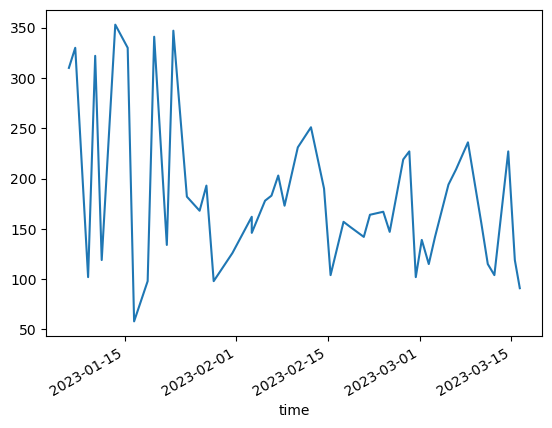

In [27]:
surface_density['density'].plot()

<AxesSubplot: xlabel='density', ylabel='value'>

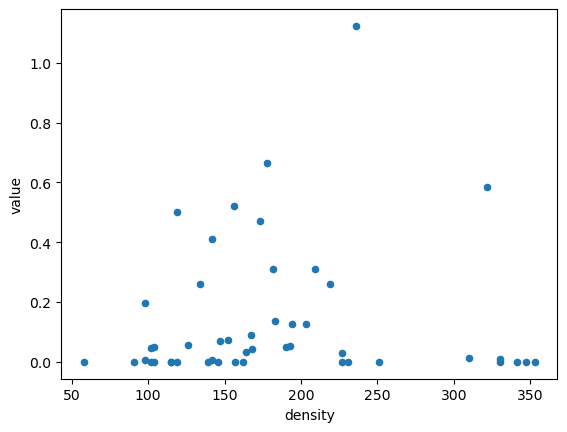

In [28]:
daily_mean_blowing_snow_flux.merge(surface_density, on='date').plot.scatter("density", 'value')

## Blowing snow vs synoptic wind speeds

In [29]:
blowing_snow_src = tidy_df_5Min[
    tidy_df_5Min.variable.isin(['SF_avg_1m_ue', 'SF_avg_2m_ue', 'w_h2o__3m_c', 'Ri_3m_c', 'RiB_3m_c'])
].pivot_table(
    index=['time'], 
    values='value', 
    columns='variable'
).reset_index()
blowing_snow_src['date'] = blowing_snow_src['time'].dt.date
blowing_snow_src

variable,time,RiB_3m_c,Ri_3m_c,SF_avg_1m_ue,SF_avg_2m_ue,w_h2o__3m_c,date
0,2022-11-29 17:02:30,0.441076,0.152030,0.0,0.0,-0.001036,2022-11-29
1,2022-11-29 17:07:30,0.819436,0.144215,0.0,0.0,-0.000371,2022-11-29
2,2022-11-29 17:12:30,0.675543,0.109604,0.0,0.0,0.000529,2022-11-29
3,2022-11-29 17:17:30,0.595939,0.070564,0.0,0.0,-0.001167,2022-11-29
4,2022-11-29 17:22:30,0.678938,0.133814,0.0,0.0,0.004871,2022-11-29
...,...,...,...,...,...,...,...
45454,2023-05-09 17:37:30,0.445049,0.119570,0.0,0.0,0.007433,2023-05-09
45455,2023-05-09 17:42:30,0.568094,0.110250,0.0,0.0,-0.006595,2023-05-09
45456,2023-05-09 17:47:30,0.364403,0.074142,NaN,0.0,0.010103,2023-05-09
45457,2023-05-09 17:52:30,0.534008,0.134658,0.0,0.0,0.001045,2023-05-09


In [30]:
synoptic_winds_df['date'] = synoptic_winds_df['time'].dt.date
synoptic_winds_df = synoptic_winds_df.groupby(["date"]).mean()
synoptic_winds_df = synoptic_winds_df.reset_index()
synoptic_winds_df

/tmp/ipykernel_84299/1695601996.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  synoptic_winds_df = synoptic_winds_df.groupby(["date"]).mean()


,date,deg,wspd
0,2022-01-01,331.675690,6.728829
1,2022-01-02,167.757889,1.274737
2,2022-01-03,241.497177,0.924294
3,2022-01-04,260.759430,5.761321
4,2022-01-05,324.879517,8.110241
...,...,...,...
488,2023-05-05,262.818176,2.500699
489,2023-05-06,151.300751,1.769925
490,2023-05-07,142.668442,3.772727
491,2023-05-08,189.905029,1.407821


In [31]:
blowing_snow_and_synoptic_winds_df = pd.merge(
    blowing_snow_src, 
    synoptic_winds_df, 
    how='left', 
    on='date'
) 

In [32]:
(alt.Chart(
    synoptic_winds_df
).mark_bar().encode(
    alt.X("wspd:Q", title='wind speed').bin(maxbins=10),
    alt.Y("count():Q")
) + 
alt.Chart(
    synoptic_winds_df
).mark_line(color='red').transform_density(
    'wspd',
    as_ = ['wind speed', 'density']
).encode(
    alt.X("wind speed:Q"),
    alt.Y("density:Q")
) 
).resolve_scale(y='independent')

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [33]:
blowing_snow_and_synoptic_winds_df['Synoptic wind speed bin'] = pd.cut(
    blowing_snow_and_synoptic_winds_df['wspd'],
    [0,1,2,3,4,5,6,7,8,9,10,np.ceil(blowing_snow_and_synoptic_winds_df['wspd'].max())]
)

blowing_snow_and_synoptic_winds_df['Synoptic wind speed bin'] = blowing_snow_and_synoptic_winds_df['Synoptic wind speed bin'].apply(lambda x: x.left + 0.5).astype('float')

In [34]:
domain = list(np.linspace(0.5, 10.5, 11))
(
    alt.Chart(
        blowing_snow_and_synoptic_winds_df.query("SF_avg_1m_ue > 0").dropna()
    ).mark_boxplot().encode(
        alt.X("Synoptic wind speed bin:O").axis(values=domain),
        alt.Y("SF_avg_1m_ue:Q").scale(type='log')
    ).properties(
        title = ['Distribution of FlowCapt measurements', 'for binned 500hPa wind speeds']
    ) | \
    alt.Chart(
        blowing_snow_and_synoptic_winds_df.query("SF_avg_1m_ue == 0").dropna()
    ).mark_bar().encode(
        alt.X("Synoptic wind speed bin:O").axis(values=domain),
        alt.Y("count():Q")
    ).properties(
        title = ['Count of zero-flux FlowCapt measurements', 'for binned 500hPa wind speeds']
    )
) & (
    alt.Chart(
        blowing_snow_and_synoptic_winds_df.query("SF_avg_2m_ue > 0").dropna()
    ).mark_boxplot().encode(
        alt.X("Synoptic wind speed bin:O").axis(values=domain),
        alt.Y("SF_avg_2m_ue:Q").scale(type='log')
    ).properties(
        title = ['Distribution of FlowCapt measurements', 'for binned 500hPa wind speeds']
    ) | \
    alt.Chart(
        blowing_snow_and_synoptic_winds_df.query("SF_avg_2m_ue == 0").dropna()
    ).mark_bar().encode(
        alt.X("Synoptic wind speed bin:O").axis(values=domain),
        alt.Y("count():Q")
    ).properties(
        title = ['Count of zero-flux FlowCapt measurements', 'for binned 500hPa wind speeds']
    )
)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


## LH Fluxes v synoptic wind speeds

In [35]:
(
alt.Chart(
    blowing_snow_and_synoptic_winds_df[blowing_snow_and_synoptic_winds_df.time.dt.hour.isin([8,9,10,11,12,13,14,15,16,17])]
).mark_boxplot(outliers=False).encode(
    alt.X("Synoptic wind speed bin:O"),
    alt.Y("w_h2o__3m_c:Q")
).properties(
    title = ['Distribution of LH fluxes', 'for binned 500hPa wind speeds']
) |
alt.Chart(
    blowing_snow_and_synoptic_winds_df[blowing_snow_and_synoptic_winds_df.time.dt.hour.isin([8,9,10,11,12,13,14,15,16,17])]
).transform_calculate(
    blowing_snow = "datum.SF_avg_1m_ue > 0 | datum.SF_avg_2m_ue > 0"
).mark_boxplot(outliers=False).encode(
    alt.X("Synoptic wind speed bin:O"),
    alt.Y("w_h2o__3m_c:Q"),
    alt.Color("blowing_snow:N"),
    alt.Column("blowing_snow:N").header(labels=False, title=None)
).properties(
    title = ['Distribution of LH fluxes for binned 500hPa wind speeds,', 'during blowing snow and not']
)
).resolve_scale(y='shared').configure_title(anchor='middle')

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


## Blowing snow vs surface snow density

In [36]:
blowing_snow_and_surface_density_df = pd.merge(
    blowing_snow_src, 
    surface_density.reset_index(), 
    how='left', 
    on='date'
) .dropna()

In [37]:
blowing_snow_and_surface_density_df['density_quantile'] = pd.qcut(
    blowing_snow_and_surface_density_df['density'],
    np.linspace(0,1,11)
)

blowing_snow_and_surface_density_df['density_quantile_middle'] = \
    blowing_snow_and_surface_density_df['density_quantile'].apply(
        lambda x: 0.5*(x.right+x.left)
    )

In [38]:
(
    alt.Chart(
        blowing_snow_and_surface_density_df.query("SF_avg_1m_ue > 0")
    ).mark_boxplot(outliers=True).encode(
        alt.X('density_quantile_middle:O').axis(labelAngle=30),
        alt.Y("SF_avg_1m_ue").scale(type='log')
    ).properties(
        title = ['Distribution of FlowCapt measurements', 'for binned snowpit surface density']
    ) | alt.Chart(
        blowing_snow_and_surface_density_df.query("SF_avg_1m_ue == 0")
    ).mark_bar().encode(
        alt.X('density_quantile_middle:O').axis(labelAngle=30),
        alt.Y("count()")
    ).properties(
        title = ['Count of zero-flux FlowCapt measurements', 'for binned snowpit surface density']
    )
) & (
    alt.Chart(
        blowing_snow_and_surface_density_df.query("SF_avg_2m_ue > 0")
    ).mark_boxplot(outliers=True).encode(
        alt.X('density_quantile_middle:O').axis(labelAngle=30),
        alt.Y("SF_avg_2m_ue").scale(type='log')
    ).properties(
        title = ['Distribution of FlowCapt measurements', 'for binned snowpit surface density']
    ) | alt.Chart(
        blowing_snow_and_surface_density_df.query("SF_avg_2m_ue == 0")
    ).mark_bar().encode(
        alt.X('density_quantile_middle:O').axis(labelAngle=30),
        alt.Y("count()")
    ).properties(
        title = ['Count of zero-flux FlowCapt measurements', 'for binned snowpit surface density']
    )
)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [39]:
(
alt.Chart(
    blowing_snow_and_surface_density_df[blowing_snow_and_surface_density_df.time_x.dt.hour.isin([8,9,10,11,12,13,14,15,16,17])]
).mark_boxplot(outliers=False).encode(
    alt.X("density_quantile_middle:O"),
    alt.Y("w_h2o__3m_c:Q")
).properties(
    title = ['Distribution of LH fluxes', 'for binned 500hPa wind speeds']
) |
alt.Chart(
    blowing_snow_and_surface_density_df[blowing_snow_and_surface_density_df.time_x.dt.hour.isin([8,9,10,11,12,13,14,15,16,17])]
).transform_calculate(
    blowing_snow = "datum.SF_avg_1m_ue > 0 | datum.SF_avg_2m_ue > 0"
).mark_boxplot(outliers=False).encode(
    alt.X("density_quantile_middle:O"),
    alt.Y("w_h2o__3m_c:Q"),
    alt.Color("blowing_snow:N"),
    alt.Column("blowing_snow:N").header(labels=False, title=None)
).properties(
    title = ['Distribution of LH fluxes for binned 500hPa wind speeds,', 'during blowing snow and not']
)
).resolve_scale(y='shared').configure_title(anchor='middle')

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


# Split dataset into blowing snow/calm assuming a 2 m/s wind speed threshold

A 2 m/s threshold for wind speed looks like a reasonable.

In [40]:
high_wind_speed_df = tidy_df_5Min[
    tidy_df_5Min.time.isin(
        tidy_df_5Min.query("variable == 'spd_3m_c'").query("value > 2").time.unique()
    )
]
low_wind_speed_df = tidy_df_5Min[
    ~ tidy_df_5Min.time.isin(
        tidy_df_5Min.query("variable == 'spd_3m_c'").query("value > 2").time.unique()
    )
]

# Plot

## Distribution of blowing snow values for wind speeds partitioned at 2 m/s

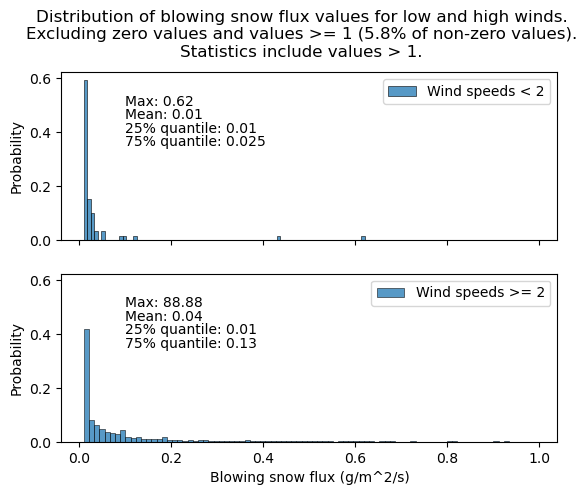

In [41]:
import seaborn as sns
fig, axes = plt.subplots(2,1, sharex=True, sharey=True)
sns.histplot(low_wind_speed_df.query("variable == 'SF_avg_1m_ue'").query("value > 0").query("value < 1").value, label = 'Wind speeds < 2', stat='probability', ax = axes[0])
[q25, q50, q75] = np.quantile(
    low_wind_speed_df.query("variable == 'SF_avg_1m_ue'").query("value > 0").value.dropna(),
    [0.25, 0.5, 0.75]
)
axes[0].annotate("Max: " + str(round(low_wind_speed_df.query("variable == 'SF_avg_1m_ue'").value.max(), 4)), xy=(0.1, 0.5))
axes[0].annotate("Mean: " + str(round(q50, 4)), xy=(0.1, 0.45))
axes[0].annotate("25% quantile: " + str(round(q25, 4)), xy=(0.1, 0.4))
axes[0].annotate("75% quantile: " + str(round(q75, 4)), xy=(0.1, 0.35))

sns.histplot(high_wind_speed_df.query("variable == 'SF_avg_1m_ue'").query("value > 0").query("value < 1").value, label = 'Wind speeds >= 2', stat='probability', ax = axes[1])
[q25, q50, q75] = np.quantile(
    high_wind_speed_df.query("variable == 'SF_avg_1m_ue'").query("value > 0").value.dropna(),
    [0.25, 0.5, 0.75]
)
axes[1].annotate("Max: " + str(round(high_wind_speed_df.query("variable == 'SF_avg_1m_ue'").value.max(), 4)), xy=(0.1, 0.5))
axes[1].annotate("Mean: " + str(round(q50, 4)), xy=(0.1, 0.45))
axes[1].annotate("25% quantile: " + str(round(q25, 4)), xy=(0.1, 0.4))
axes[1].annotate("75% quantile: " + str(round(q75, 4)), xy=(0.1, 0.35))

axes[0].legend()
axes[1].legend()
axes[1].set_xlabel("Blowing snow flux (g/m^2/s)")
percent_greater_than_1 = round(
    100*len(tidy_df_5Min.query("variable == 'SF_avg_1m_ue'").query("value > 1")) / len(tidy_df_5Min.query("variable == 'SF_avg_1m_ue'").query("value > 0")),
     1
)
plt.suptitle(
    f"Distribution of blowing snow flux values for low and high winds.\nExcluding zero values and values >= 1 ({percent_greater_than_1}% of non-zero values).\nStatistics include values > 1.",
    y=1.01
)
plt.show()

## Cumulative distribution of sublimation measurements over the range of (non-zero) FlowCapt measurement quantiles

In [42]:
nonzero_blowing_snow_data = tidy_df_5Min[
    tidy_df_5Min.time.isin(
        tidy_df_5Min[tidy_df_5Min.variable.isin(['SF_avg_1m_ue', 'SF_avg_2m_ue'])].query(
            f"value > 0"
        ).time
    )
]

In [43]:
cum_blowing_sublimation_df = nonzero_blowing_snow_data[
    nonzero_blowing_snow_data['variable'].isin(['w_h2o__3m_c', 'SF_avg_1m_ue'])
].pivot_table(
    index=['time'], 
    values='value', 
    columns='variable'
).reset_index()

cum_blowing_sublimation_df['sublimation (mm)'] = cum_blowing_sublimation_df['w_h2o__3m_c']*60*5*.001

# add jitter so that pd.qcut can work even though there are a ton of the same values at the smallest values that the flowcapt can measure (See the logscale scatter plots above)
def jitter(a_series, noise_reduction=100000000):
    return (np.random.random(len(a_series))*a_series.std()/noise_reduction)-(a_series.std()/(2*noise_reduction))

cum_blowing_sublimation_df['FlowCapt measurement quantile'] = pd.qcut(
    cum_blowing_sublimation_df['SF_avg_1m_ue'] +  jitter(cum_blowing_sublimation_df['SF_avg_1m_ue']),
    np.linspace(0,100, 101)*0.01,
    labels = np.linspace(1,100, 100)*0.01
)

cum_blowing_sublimation_quantiles_df = pd.DataFrame(
    cum_blowing_sublimation_df.groupby("FlowCapt measurement quantile")['sublimation (mm)'].sum()
)
cum_blowing_sublimation_quantiles_df['Cumulative sublimation (mm)'] = cum_blowing_sublimation_quantiles_df['sublimation (mm)'].cumsum()
cum_blowing_sublimation_quantiles_df

alt.Chart(cum_blowing_sublimation_quantiles_df.reset_index()).mark_point().encode(
    x = alt.X('FlowCapt measurement quantile:Q'),
    y = 'Cumulative sublimation (mm)'
).properties(width=200, height=200)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


# Split dataset into blowing snow/calm using a blowing snow sensitivity threshold

## Set the measured blowing snow threshold value here.

Values considered thus far: {0.00, 0.01, 0.025}.

In [44]:
BLOWING_SNOW_SENSITIVITY_THRESHOLD = 0.00

# Add q (mixing ratio) gradient variable

In [45]:
new_variable = (
    tidy_df_5Min.query("variable == 'mixingratio_3m_c'").value.values
    - tidy_df_5Min.query("variable == 'Tsurfmixingratio_rad_c'").value.values
) / 3

tidy_df_5Min = tidy.tidy_df_add_variable(
    tidy_df_5Min,
    new_variable,
    "q_gradient_3m_c",
    "mixing ratio gradient",
    3,
    'c'
)

# Add Net Rad variable

In [46]:
net_radiation_values = (
    (
        tidy_df_5Min.query("variable == 'Rsw_in_9m_d'")['value'].values
        +
        tidy_df_5Min.query("variable == 'Rlw_in_9m_d'")['value'].values
    ) - (
        tidy_df_5Min.query("variable == 'Rsw_out_9m_d'")['value'].values
        +
        tidy_df_5Min.query("variable == 'Rlw_out_9m_d'")['value'].values
    )
)



tidy_df_5Min = tidy.tidy_df_add_variable(
    tidy_df_5Min,
    net_radiation_values,
    'Rnet_9m_d',
    'net radiation',
    9,
    'd'
)


# Calculate total sublimation during blowing snow vs calm conditions

## Split 5 minute data into blowing snow and calm datasets

In [47]:
blowing_snow_data = tidy_df_5Min[
    tidy_df_5Min.time.isin(
        tidy_df_5Min[tidy_df_5Min.variable.isin(['SF_avg_1m_ue', 'SF_avg_2m_ue'])].query(
            f"value > {BLOWING_SNOW_SENSITIVITY_THRESHOLD}"
        ).time
    )
]
calm_data = tidy_df_5Min[
    ~ tidy_df_5Min.time.isin(
        tidy_df_5Min[tidy_df_5Min.variable.isin(['SF_avg_1m_ue', 'SF_avg_2m_ue'])].query(f"value > {BLOWING_SNOW_SENSITIVITY_THRESHOLD}").time
    )
]
len(blowing_snow_data.time.unique()), len(calm_data.time.unique()), len(blowing_snow_data.time.unique()), len(calm_data.time.unique())

(6187, 40181, 6187, 40181)

In [48]:
print(len(tidy_df_5Min)), \
print(len(blowing_snow_data) + len(calm_data))

23508576
23508576


(None, None)

In [49]:
mm_sublimated_df = pd.DataFrame(
    calm_data.query("measurement == 'w_h2o_'").groupby(
        ["height", "tower"]
    ).value.sum()*60*5*0.001
).rename(
    columns={'value': 'calm'}
).merge(
    pd.DataFrame(
        blowing_snow_data.query("measurement == 'w_h2o_'").groupby(
            ["height", "tower"]
        ).value.sum()*60*5*0.001)
    .rename(
        columns={'value': 'blowing snow'}
    ),
    on = ['height', 'tower']
)
mm_sublimated_df['total mm sublimation'] = mm_sublimated_df['blowing snow'] + mm_sublimated_df['calm'] 
mm_sublimated_df['percent blowing snow'] = round(
    100*mm_sublimated_df['blowing snow']/mm_sublimated_df['total mm sublimation'],
    1
)
mm_sublimated_df

calm  blowing snow  total mm sublimation  \
height tower                                                   
1.0    d       11.568293      7.178938             18.747231   
       ue      15.230204      8.637233             23.867437   
       uw      -1.108608      5.232382              4.123774   
2.0    c       17.886746     11.810511             29.697258   
3.0    c       20.276771     14.182829             34.459600   
       d       15.348091     13.557877             28.905969   
       ue     -16.728912     14.310556             -2.418356   
       uw      21.248110     13.144821             34.392931   
5.0    c       21.665499     15.776082             37.441581   
10.0   c      661.360360     24.438196            685.798556   
       d       23.097216     16.090334             39.187550   
       ue      19.817661     16.867280             36.684941   
       uw      19.420448     16.963557             36.384005   
15.0   c       17.501946     15.078298             32.580244   
20.0   c       20.335237     18.402718             38.737955   

              percent blowing snow  
height tower                        
1.0    d                      38.3  
       ue                     36.2  
       uw                    126.9  
2.0    c                      39.8  
3.0    c                      41.2  
       d                      46.9  
       ue                   -591.7  
       uw                     38.2  
5.0    c                      42.1  
10.0   c                       3.6  
       d                      41.1  
       ue                     46.0  
       uw                     46.6  
15.0   c                      46.3  
20.0   c                      47.5

# Plot

## Total seasonal sublimation during blowing snow and calm conditions

In [50]:
src = mm_sublimated_df.drop([
    (3, 'ue'),
    (10, 'c'),
    (1, 'uw')
])
mean_percent_blowing_snow = round(src['percent blowing snow'].mean(),1)
src = src.melt(ignore_index=False, value_vars=['calm', 'blowing snow']).reset_index()

alt.Chart(
    src
).transform_filter(alt.FieldOneOfPredicate('height', [3, 10])).mark_bar().encode(
    x="tower:N",
    # xOffset = 'variable:N',
    y=alt.Y("value:Q").title("Seasonal sublimation (mm)"),
    color="variable:N",
    column="height:N"
).configure_legend(orient='top').properties(
    title=[
        f'Threshold: {BLOWING_SNOW_SENSITIVITY_THRESHOLD}',
        f'Sublimation during blowing snow: {mean_percent_blowing_snow}%'
    ]
)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


## Blowing Snow/Calm sublimation throughout the season

Only data prior to April 9 (when melt began) and after 11/30 (so we don't have 1 day of data for a month)

In [51]:
src_blow = blowing_snow_data[blowing_snow_data['time'] < '2023-04-09']
src_calm = calm_data[calm_data['time'] < '2023-04-09']

src_blow = src_blow.assign(month = src_blow['time'].dt.month).query("variable == 'w_h2o__3m_c'")
src_calm = src_calm.assign(month = src_calm['time'].dt.month).query("variable == 'w_h2o__3m_c'")

src_blow = src_blow.assign(type = 'blowing snow')
src_calm = src_calm.assign(type = 'calm')
src = pd.concat([
    src_blow,
    src_calm
])
src['time_water_year_adj'] = src['time'] + dt.timedelta(days = 92)
src['week of water year'] = src['time_water_year_adj'].dt.week

/tmp/ipykernel_84299/222469941.py:14: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  src['week of water year'] = src['time_water_year_adj'].dt.week


In [52]:
alt.Chart(src[src['time'].dt.month != 11]).mark_boxplot(outliers=False).encode(
    alt.X("month(time):N").sort([11,12,1,2,3,4]),
    alt.Y("value:Q").title(["Latent heat flux (g/m^2/s),", "(5 minute averages)"]),
    alt.XOffset("type:N"),
    alt.Color("type:N")
).properties(
    title=["Eddy covariance measurements of latent heat flux", "during blowing snow and calm conditions"]
)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [53]:
alt.Chart(src).mark_boxplot(outliers=False).encode(
    alt.X("week of water year:O"),
    alt.Y("value:Q").title(["Latent heat flux (g/m^2/s),", "(5 minute averages)"]),\
    alt.XOffset("type:N"),
    alt.Color("type:N")
).properties(
    title=["Eddy covariance measurements of latent heat flux", "during blowing snow and calm conditions"],
    width=800
)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


## Correlations of Blowing Snow Flux and Precipitation

In [54]:
def average_snowflux_values(m1, m2):
    if m1 > 0 and m2 > 0:
        return (m1 + m2) / 2
    elif m1 > 0 and m2 == 0:
        return m1
    elif m2 > 0 and m1 == 0:
        return m2
    elif m1 == 0 and m2 == 0:
        return 0
    elif np.isnan(m1):
        return m2
    elif np.isnan(m2):
        return m1
    else:
        print("WTF HAPPENED?")
        return np.nan

combo_df = blowing_snow_data[blowing_snow_data.variable.isin(['SF_avg_1m_ue', 'SF_avg_2m_ue', 'w_h2o__3m_c'])].pivot_table(
    index=['time'],
    values='value',
    columns='variable'
).reset_index().merge(precip_5min_df, on='time')
combo_df['SF_avg'] = combo_df.apply(
    lambda row: average_snowflux_values(row['SF_avg_1m_ue'], row['SF_avg_2m_ue']),
    axis=1
)
combo_df.head()

,time,SF_avg_1m_ue,SF_avg_2m_ue,w_h2o__3m_c,precip_rate,SF_avg
0,2022-12-02 01:52:30,0.01,0.02,-0.003112,3.0212,0.015
1,2022-12-02 01:57:30,0.01,0.02,0.000102,3.6092,0.015
2,2022-12-02 02:02:30,0.01,0.01,0.000221,1.9678,0.010
3,2022-12-02 02:12:30,0.03,0.06,-0.000963,5.2908,0.045
4,2022-12-02 02:17:30,0.04,0.08,-0.002835,4.2056,0.060


In [55]:
(alt.Chart(combo_df).mark_circle(size=5, opacity=0.25).encode(
    alt.X('precip_rate').title("Disdrometer precip rate (mm/hr)"),
    alt.Y('SF_avg').scale(type='log'),
).properties(height = 100) & alt.Chart(
    combo_df[['precip_rate']]
).transform_density(
    'precip_rate',
    as_=['precip_rate', 'density'],
    groupby=['type']
).mark_line().encode(
    alt.X('precip_rate').title("Disdrometer precip rate (mm/hr)"),
    y='density:Q'
).properties(height = 200)).display(renderer='svg')

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [56]:
combo_df['precip'] = combo_df['precip_rate'] > 0

In [57]:
combo_df_no_precip = combo_df[ ~ combo_df.precip]

combo_df_all_precip = combo_df.query("precip")
combo_df_all_precip['precip rate quantile'] = pd.qcut(
    combo_df_all_precip['precip_rate'], 
    8
)
# combo_df_all_precip['precip rate quantile'] = combo_df_all_precip['precip rate quantile'].astype(str)
combo_df_all_precip['precip rate quantile'] = combo_df_all_precip['precip rate quantile'].apply(lambda duo: str(round(duo.left, 3)) + "-" + str(round(duo.right, 3)))

/tmp/ipykernel_84299/757767484.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combo_df_all_precip['precip rate quantile'] = pd.qcut(
/tmp/ipykernel_84299/757767484.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combo_df_all_precip['precip rate quantile'] = combo_df_all_precip['precip rate quantile'].apply(lambda duo: str(round(duo.left, 3)) + "-" + str(round(duo.right, 3)))


In [58]:
(
    alt.Chart(combo_df).mark_boxplot(outliers=False).encode(
        alt.X('precip:N'),
        alt.Y('SF_avg:Q'),   
    ).properties(
        title = ['FlowCapt measurements', '(not) during snowfall'],
        width=100
    ) 
        | 
    alt.Chart(combo_df_all_precip).mark_boxplot(outliers=False).encode(
        alt.X('precip rate quantile:O').axis(labelAngle=20),
        alt.Y('SF_avg'),   
    ).properties(
        title = ['FlowCapt measurements during', 'different precip rates'],
        width=300, 
        height=200
    )
).resolve_scale(y='shared').display(renderer='svg')

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


### Cumulative sublimation per precipitation rate during snowfall

In [59]:
combo_df_all_precip

combo_df_all_precip['precip rate quantile'] = pd.qcut(
    combo_df_all_precip['precip_rate'],
    np.linspace(0,100, 101)*0.01,
    labels = np.linspace(1,100, 100)*0.01
)

combo_df_all_precip['sublimation (mm)'] = combo_df_all_precip['w_h2o__3m_c']*60*5*.001

cumulative_sublimation_per_precip_rate_quantile_df = pd.DataFrame(
    combo_df_all_precip.groupby("precip rate quantile")['sublimation (mm)'].sum()
).reset_index()

cumulative_sublimation_per_precip_rate_quantile_df['Cumulative sublimation (mm)'] = cumulative_sublimation_per_precip_rate_quantile_df['sublimation (mm)'].cumsum()
cumulative_sublimation_per_precip_rate_quantile_df

/tmp/ipykernel_84299/3784268783.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combo_df_all_precip['precip rate quantile'] = pd.qcut(
/tmp/ipykernel_84299/3784268783.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combo_df_all_precip['sublimation (mm)'] = combo_df_all_precip['w_h2o__3m_c']*60*5*.001


,precip rate quantile,sublimation (mm),Cumulative sublimation (mm)
0,0.01,0.179110,0.179110
1,0.02,0.086792,0.265902
2,0.03,0.084738,0.350641
3,0.04,0.087817,0.438458
4,0.05,0.082306,0.520764
...,...,...,...
95,0.96,0.059503,5.282558
96,0.97,0.081155,5.363713
97,0.98,0.087928,5.451640
98,0.99,0.106632,5.558272


In [60]:
alt.Chart(cumulative_sublimation_per_precip_rate_quantile_df).mark_point().encode(
    alt.X("precip rate quantile:Q"),
    alt.Y("Cumulative sublimation (mm)")
).properties(width=200, height=200).display(renderer='svg')

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [61]:
scipy.stats.spearmanr(
        blowing_snow_data[blowing_snow_data.time.dt.hour.isin([8,9,10,11,12,13,14,15,16])].query("variable == 'Rsw_in_9m_d'").value.values,
        blowing_snow_data[blowing_snow_data.time.dt.hour.isin([8,9,10,11,12,13,14,15,16])].query("variable == 'w_h2o__3m_c'").value.values,
        nan_policy='omit'
    )

SignificanceResult(statistic=0.4017652950255497, pvalue=6.282875636608324e-116)

In [62]:
def calm_v_blowing_plot(blowing_snow_data, calm_data):
    fig, axes = plt.subplots(2,3, figsize=(12, 6.4), sharey=True, sharex="col")
    axes[0,0].set_ylabel("Blowing snow data\n\nLatent heat flux (g/m^2/s)")
    x_vals_00 = blowing_snow_data[blowing_snow_data.time.dt.hour.isin([8,9,10,11,12,13,14,15,16])].query("variable == 'Rsw_in_9m_d'").value
    y_vals_00 = blowing_snow_data[blowing_snow_data.time.dt.hour.isin([8,9,10,11,12,13,14,15,16])].query("variable == 'w_h2o__3m_c'").value
    statistic_result = scipy.stats.spearmanr(
        x_vals_00,
        y_vals_00,
        nan_policy='omit'
    )
    print(statistic_result)
    axes[0,0].set_title("Spearman r: " + str(round(statistic_result.statistic, 2)) + ", p: " + str(round(statistic_result.pvalue, 4)))
    axes[0,0].scatter(
        x_vals_00,
        y_vals_00,
        s=0.2,
        alpha=0.2
    )
    axes[1,0].set_ylabel("Calm data\n\nLatent heat flux (g/m^2/s)")
    axes[1,0].set_xlabel("Incoming shortwave radiation (W/m^2)")
    x_vals_10 = calm_data[calm_data.time.dt.hour.isin([8,9,10,11,12,13,14,15,16])].query("variable == 'Rsw_in_9m_d'").value
    y_vals_10 = calm_data[calm_data.time.dt.hour.isin([8,9,10,11,12,13,14,15,16])].query("variable == 'w_h2o__3m_c'").value
    statistic_result = scipy.stats.spearmanr(
        x_vals_10,
        y_vals_10,
        nan_policy='omit'
    )
    print(statistic_result)
    axes[1,0].set_title("Spearman r: " + str(round(statistic_result.statistic, 2)) + ", p: " + str(round(statistic_result.pvalue, 4)))
    axes[1,0].scatter(
        x_vals_10,
        y_vals_10,
        s=0.2,
        alpha=0.2
    )
    x_vals_01 = blowing_snow_data[blowing_snow_data.time.dt.hour.isin([8,9,10,11,12,13,14,15,16])].query("variable == 'spd_3m_c'").value
    y_vals_01 = blowing_snow_data[blowing_snow_data.time.dt.hour.isin([8,9,10,11,12,13,14,15,16])].query("variable == 'w_h2o__3m_c'").value
    statistic_result = scipy.stats.spearmanr(
        x_vals_01,
        y_vals_01,
        nan_policy='omit'
    )
    print(statistic_result)
    axes[0,1].set_title("Spearman r: " + str(round(statistic_result.statistic, 2)) + ", p: " + str(round(statistic_result.pvalue, 4)))
    axes[0,1].scatter(
        x_vals_01,
        y_vals_01,
        s=0.2,
        alpha=0.2
    )
    axes[1,1].set_xlabel("Wind speed (m/s)")
    x_vals_11 = calm_data[calm_data.time.dt.hour.isin([8,9,10,11,12,13,14,15,16])].query("variable == 'spd_3m_c'").value
    y_vals_11 = calm_data[calm_data.time.dt.hour.isin([8,9,10,11,12,13,14,15,16])].query("variable == 'w_h2o__3m_c'").value
    statistic_result = scipy.stats.spearmanr(
        x_vals_11,
        y_vals_11,
        nan_policy='omit'
    )
    print(statistic_result)
    axes[1,1].set_title("Spearman r: " + str(round(statistic_result.statistic, 2)) + ", p: " + str(round(statistic_result.pvalue, 4)))
    axes[1,1].scatter(
        x_vals_11,
        y_vals_11,
        s=0.2,
        alpha=0.2
    )
    x_vals_02 = blowing_snow_data[blowing_snow_data.time.dt.hour.isin([8,9,10,11,12,13,14,15,16])].query("variable == 'q_gradient_3m_c'").value
    y_vals_02 = blowing_snow_data[blowing_snow_data.time.dt.hour.isin([8,9,10,11,12,13,14,15,16])].query("variable == 'w_h2o__3m_c'").value
    statistic_result = scipy.stats.spearmanr(
        x_vals_02,
        y_vals_02,
        nan_policy='omit'
    )
    print(statistic_result)
    axes[0,2].set_title("Spearman r: " + str(round(statistic_result.statistic, 2)) + ", p: " + str(round(statistic_result.pvalue, 4)))
    axes[0,2].scatter(
        x_vals_02,
        y_vals_02,
        s=0.2,
        alpha=0.2
    )
    axes[1,2].set_xlabel("Mixing ratio gradient (m^-1)")
    x_vals_12 = calm_data[calm_data.time.dt.hour.isin([8,9,10,11,12,13,14,15,16])].query("variable == 'q_gradient_3m_c'").value
    y_vals_12 = calm_data[calm_data.time.dt.hour.isin([8,9,10,11,12,13,14,15,16])].query("variable == 'w_h2o__3m_c'").value
    statistic_result = scipy.stats.spearmanr(
        x_vals_12,
        y_vals_12,
        nan_policy='omit'
    )
    print(statistic_result)
    axes[1,2].set_title("Spearman r: " + str(round(statistic_result.statistic, 2)) + ", p: " + str(round(statistic_result.pvalue, 4)))
    axes[1,2].scatter(
        x_vals_12,
        y_vals_12,
        s=0.2,
        alpha=0.2
    )
    plt.show()

### With wind Rsw, Wind speed, and q gradient

#### All data

SignificanceResult(statistic=0.4017652950255497, pvalue=6.282875636608324e-116)
SignificanceResult(statistic=0.41694615741142077, pvalue=0.0)
SignificanceResult(statistic=0.3154541948763909, pvalue=8.481401054528477e-70)
SignificanceResult(statistic=0.5335924365922582, pvalue=0.0)
SignificanceResult(statistic=-0.5573147238016166, pvalue=1.1593290024414873e-242)
SignificanceResult(statistic=-0.616371522460161, pvalue=0.0)


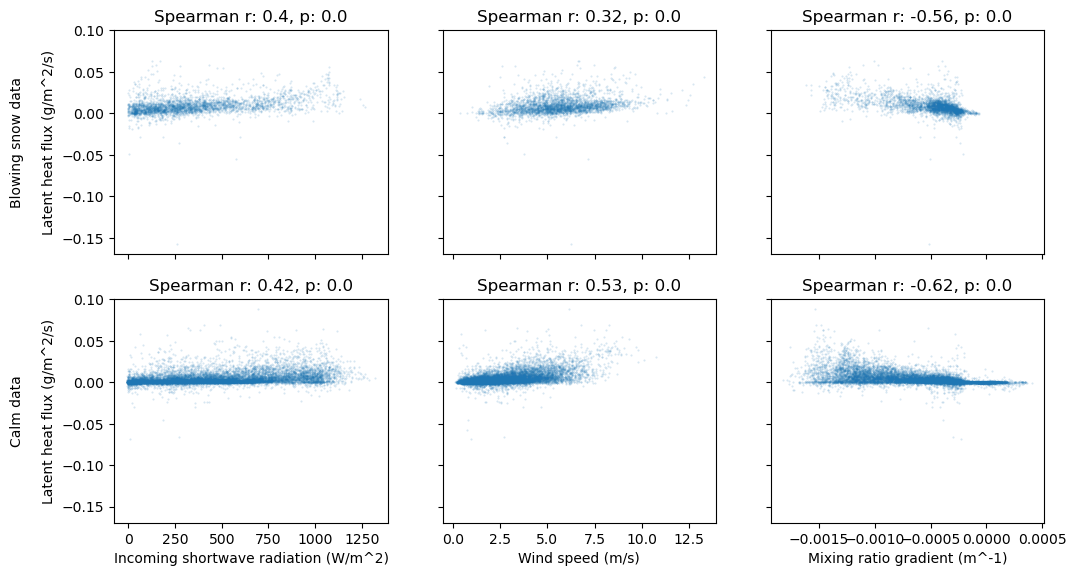

In [63]:
calm_v_blowing_plot(blowing_snow_data, calm_data)

#### Create datasets for different stability regimes

In [64]:
blowing_snow_data_stable = blowing_snow_data[blowing_snow_data['time'].isin(
    blowing_snow_data.query("variable == 'Ri_3m_c'").query("value > 0.25").time.unique()
)]

calm_data_stable = calm_data[calm_data['time'].isin(
    calm_data.query("variable == 'Ri_3m_c'").query("value > 0.25").time.unique()
)]

blowing_snow_data_unstable = blowing_snow_data[blowing_snow_data['time'].isin(
    blowing_snow_data.query("variable == 'Ri_3m_c'").query("value < -0.25").time.unique()
)]

calm_data_unstable = calm_data[calm_data['time'].isin(
    calm_data.query("variable == 'Ri_3m_c'").query("value < -0.25").time.unique()
)]

blowing_snow_data_neutral = blowing_snow_data[blowing_snow_data['time'].isin(
    blowing_snow_data.query("variable == 'Ri_3m_c'").query("value >= -0.25").query("value <= 0.25").time.unique()
)]

calm_data_neutral = calm_data[calm_data['time'].isin(
    calm_data.query("variable == 'Ri_3m_c'").query("value >= -0.25").query("value <= 0.25").time.unique()
)]


#### Plot LH Flux distributions for different stability regimes

In [65]:
tidy_5min_by_stability_and_blowing_df = pd.concat([
    blowing_snow_data_stable.assign(stability = 'stable').assign(type = 'blowing_snow'),
    blowing_snow_data_neutral.assign(stability = 'neutral').assign(type = 'blowing_snow'),
    blowing_snow_data_unstable.assign(stability = 'unstable').assign(type = 'blowing_snow'),
    calm_data_stable.assign(stability = 'stable').assign(type = 'calm'),
    calm_data_neutral.assign(stability = 'neutral').assign(type = 'calm'),
    calm_data_unstable.assign(stability = 'unstable').assign(type = 'calm')
])

In [66]:
tidy_df_5Min

,time,variable,value,height,tower,measurement
0,2022-11-29 17:02:30,RH_16m_c,70.132240,16.0,c,RH
1,2022-11-29 17:07:30,RH_16m_c,72.489586,16.0,c,RH
2,2022-11-29 17:12:30,RH_16m_c,68.886726,16.0,c,RH
3,2022-11-29 17:17:30,RH_16m_c,66.287270,16.0,c,RH
4,2022-11-29 17:22:30,RH_16m_c,60.981804,16.0,c,RH
...,...,...,...,...,...,...
46363,2023-05-09 17:37:30,Rnet_9m_d,136.290424,9.0,d,net radiation
46364,2023-05-09 17:42:30,Rnet_9m_d,128.972275,9.0,d,net radiation
46365,2023-05-09 17:47:30,Rnet_9m_d,120.564877,9.0,d,net radiation
46366,2023-05-09 17:52:30,Rnet_9m_d,112.463093,9.0,d,net radiation


In [67]:
tidy_5min_by_stability_and_blowing_df

,time,variable,value,height,tower,measurement,stability,type
706,2022-12-02 03:52:30,RH_16m_c,83.049515,16.0,c,RH,stable,blowing_snow
727,2022-12-02 05:37:30,RH_16m_c,87.801613,16.0,c,RH,stable,blowing_snow
1509,2022-12-04 22:47:30,RH_16m_c,85.672691,16.0,c,RH,stable,blowing_snow
1556,2022-12-05 02:42:30,RH_16m_c,96.926758,16.0,c,RH,stable,blowing_snow
1592,2022-12-05 05:42:30,RH_16m_c,91.466423,16.0,c,RH,stable,blowing_snow
...,...,...,...,...,...,...,...,...
45398,2023-05-06 09:12:30,Rnet_9m_d,26.468014,9.0,d,net radiation,unstable,calm
45423,2023-05-06 11:17:30,Rnet_9m_d,147.562195,9.0,d,net radiation,unstable,calm
45727,2023-05-07 12:37:30,Rnet_9m_d,138.866299,9.0,d,net radiation,unstable,calm
45729,2023-05-07 12:47:30,Rnet_9m_d,156.768946,9.0,d,net radiation,unstable,calm


In [68]:
src = tidy_5min_by_stability_and_blowing_df[
        tidy_5min_by_stability_and_blowing_df.time.dt.hour.isin([8,9,19,11,12,13,14,15,16,17])
    ].query("variable == 'w_h2o__3m_c'")

(   
    alt.Chart(
        src
    ).transform_density(
        'value',
        as_=["w_h2o__3m_c", "density"],
        groupby=['stability']
    ).mark_line().encode(
        alt.X("w_h2o__3m_c:Q").scale(domain=[-0.01,0.025], clamp=True),
        alt.Y("density:Q"),
        alt.Color("stability:N")
    ).properties(title=['Distribution of LH flux measurements,', 'by stability regime'])
    | 
    alt.Chart(
        src
    ).transform_density(
        'value',
        as_=["w_h2o__3m_c", "density"],
        groupby=['stability', 'type']
    ).mark_line().encode(
        alt.X("w_h2o__3m_c:Q").scale(domain=[-0.01,0.025], clamp=True),
        alt.Y("density:Q"),
        alt.Color("stability:N"),
        alt.StrokeDash("type:N")
    ).properties(title=['Distribution of LH flux measurements,', 'by stability regime and during/not during blowing snow'])
).resolve_scale(color='independent', strokeDash='independent').configure_legend(orient='top')

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


SignificanceResult(statistic=0.2842105263157895, pvalue=0.012840315628750118)
SignificanceResult(statistic=0.3177682756066883, pvalue=4.092340954735256e-69)
SignificanceResult(statistic=0.4528776486671223, pvalue=3.995495310183174e-05)
SignificanceResult(statistic=0.217463255929414, pvalue=2.0541509994487043e-32)
SignificanceResult(statistic=-0.6200683526999317, pvalue=2.3255829489254505e-09)
SignificanceResult(statistic=-0.5007724012747518, pvalue=3.9564861565544213e-184)


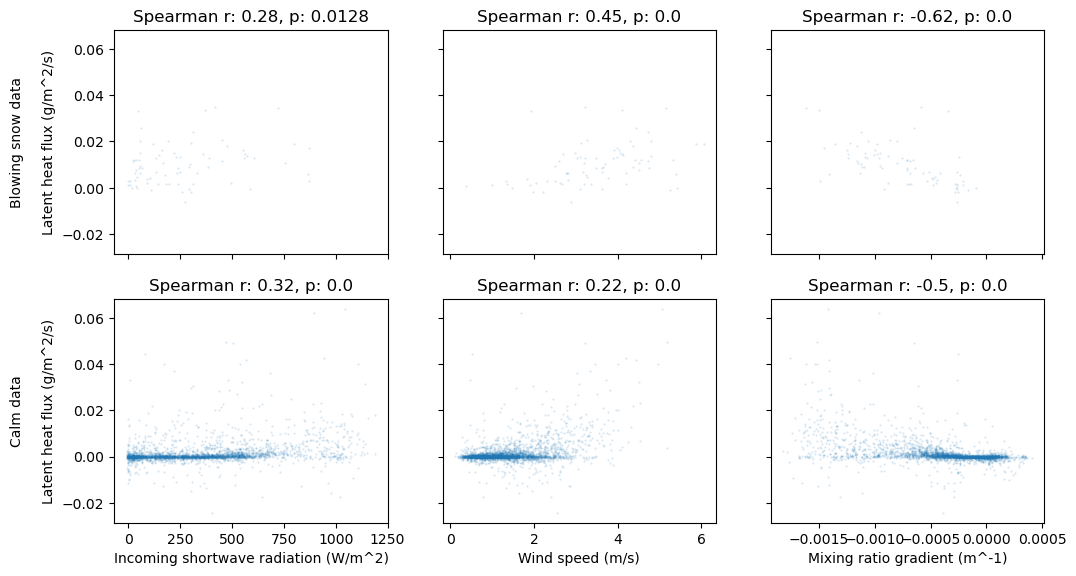

SignificanceResult(statistic=0.309090909090909, pvalue=0.3848412302612835)
SignificanceResult(statistic=0.5131010396489538, pvalue=1.8598592947869802e-96)
SignificanceResult(statistic=0.3939393939393939, pvalue=0.25999776683488757)
SignificanceResult(statistic=0.33632274913744226, pvalue=3.318357887765073e-39)
SignificanceResult(statistic=-0.5636363636363636, pvalue=0.08972402831709125)
SignificanceResult(statistic=-0.642144367043522, pvalue=2.7312098360893247e-167)


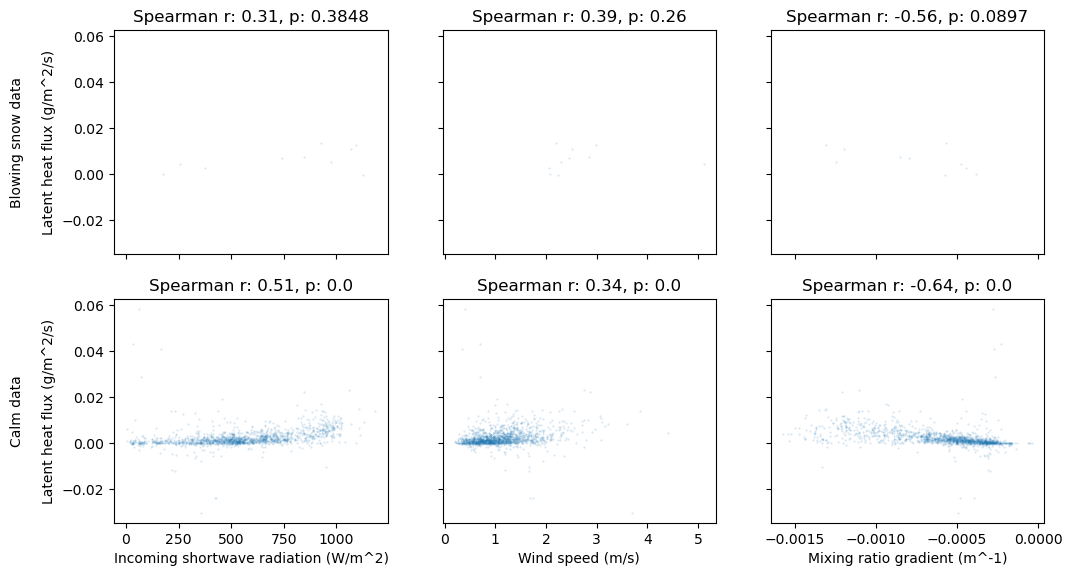

SignificanceResult(statistic=0.4056686988496488, pvalue=1.090702107014968e-114)
SignificanceResult(statistic=0.4109881202339852, pvalue=0.0)
SignificanceResult(statistic=0.32164313644660975, pvalue=2.0905239024181677e-70)
SignificanceResult(statistic=0.6026704864542123, pvalue=0.0)
SignificanceResult(statistic=-0.5557550187055931, pvalue=1.7305584439115939e-233)
SignificanceResult(statistic=-0.6033376363378786, pvalue=0.0)


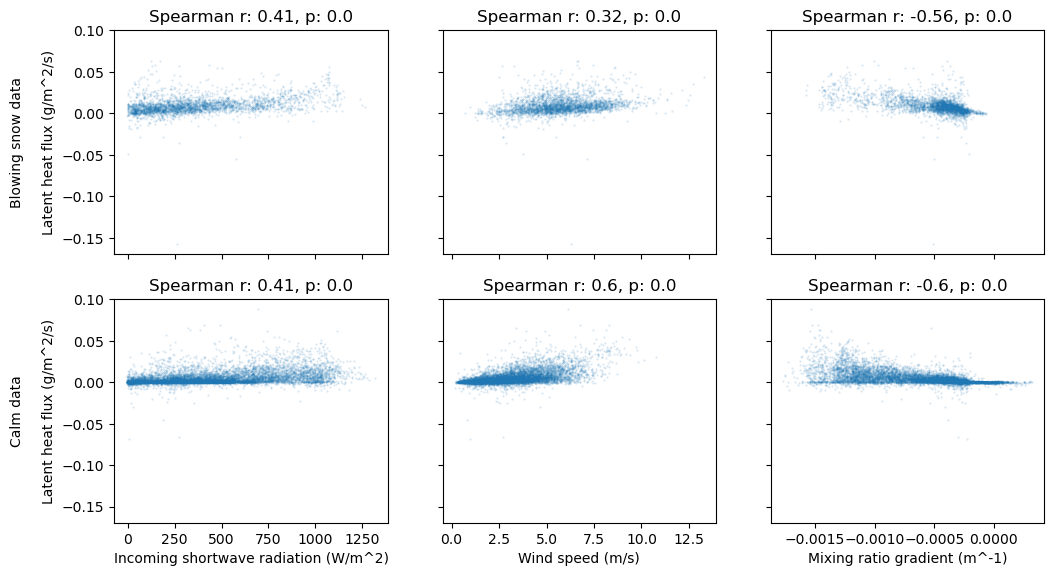

In [69]:
calm_v_blowing_plot(blowing_snow_data_stable, calm_data_stable)
calm_v_blowing_plot(blowing_snow_data_unstable, calm_data_unstable)
calm_v_blowing_plot(blowing_snow_data_neutral, calm_data_neutral)

### With Rsw, separately for +/- q gradient

#### Blowing snow data only

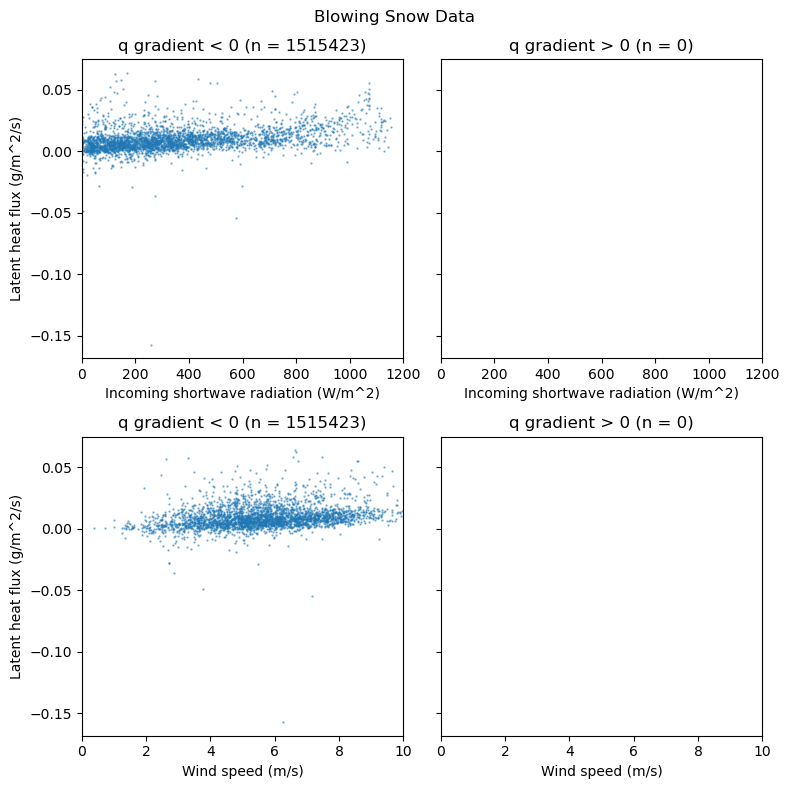

In [70]:
src = blowing_snow_data[blowing_snow_data.time.dt.hour.isin([8,9,10,11,12,13,14,15,16])]
src_pos_qgrad = src[src['time'].isin(blowing_snow_data.query("variable == 'q_gradient_3m_c'").query("value > 0").time)]
src_neg_qgrad = src[src['time'].isin(blowing_snow_data.query("variable == 'q_gradient_3m_c'").query("value <= 0").time)]

fig, axes = plt.subplots(2,2, figsize=(8,8), sharey=True)
axes[0,0].scatter(
    src_neg_qgrad.query("variable == 'Rsw_in_9m_d'").value,
    src_neg_qgrad.query("variable == 'w_h2o__3m_c'").value,
    s=0.5,
    alpha=0.5
)
axes[0,0].set_title(f"q gradient < 0 (n = {len(src_neg_qgrad)})")
axes[0,0].set_ylabel("Latent heat flux (g/m^2/s)")
axes[0,0].set_xlabel("Incoming shortwave radiation (W/m^2)")
axes[0,0].set_xlim(0,1200)
axes[0,1].scatter(
    src_pos_qgrad.query("variable == 'Rsw_in_9m_d'").value,
    src_pos_qgrad.query("variable == 'w_h2o__3m_c'").value,
    s=0.5,
    alpha=0.5
)
axes[0,1].set_title(f"q gradient > 0 (n = {len(src_pos_qgrad)})")
axes[0,1].set_xlabel("Incoming shortwave radiation (W/m^2)")
axes[0,1].set_xlim(0,1200)
axes[1,0].scatter(
    src_neg_qgrad.query("variable == 'spd_3m_c'").value,
    src_neg_qgrad.query("variable == 'w_h2o__3m_c'").value,
    s=0.5,
    alpha=0.5
)
axes[1,0].set_title(f"q gradient < 0 (n = {len(src_neg_qgrad)})")
axes[1,0].set_ylabel("Latent heat flux (g/m^2/s)")
axes[1,0].set_xlabel("Wind speed (m/s)")
axes[1,0].set_xlim(0,10)
axes[1,1].scatter(
    src_pos_qgrad.query("variable == 'spd_3m_c'").value,
    src_pos_qgrad.query("variable == 'w_h2o__3m_c'").value,
    s=0.5,
    alpha=0.5
)
axes[1,1].set_title(f"q gradient > 0 (n = {len(src_pos_qgrad)})")
axes[1,1].set_xlabel("Wind speed (m/s)")

axes[1,1].set_xlim(0,10)
plt.suptitle("Blowing Snow Data")
plt.tight_layout()

#### Calm data only

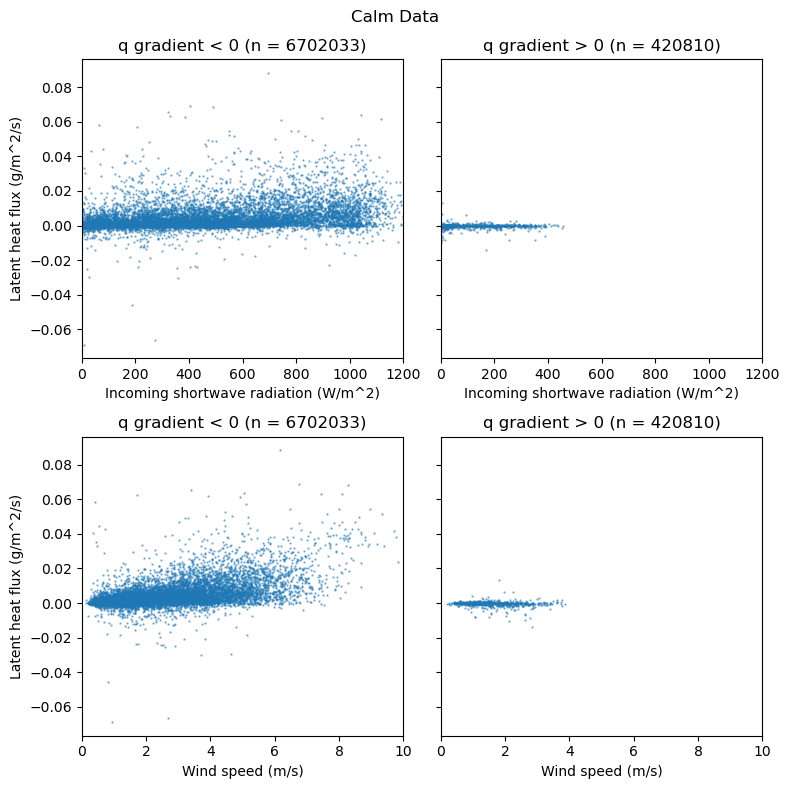

In [71]:
src = calm_data[calm_data.time.dt.hour.isin([8,9,10,11,12,13,14,15,16])]
src_pos_qgrad = src[src['time'].isin(calm_data.query("variable == 'q_gradient_3m_c'").query("value > 0").time)]
src_neg_qgrad = src[src['time'].isin(calm_data.query("variable == 'q_gradient_3m_c'").query("value <= 0").time)]


fig, axes = plt.subplots(2,2, figsize=(8,8), sharey=True)
axes[0,0].scatter(
    src_neg_qgrad.query("variable == 'Rsw_in_9m_d'").value,
    src_neg_qgrad.query("variable == 'w_h2o__3m_c'").value,
    s=0.5,
    alpha=0.5
)
axes[0,0].set_title(f"q gradient < 0 (n = {len(src_neg_qgrad)})")
axes[0,0].set_ylabel("Latent heat flux (g/m^2/s)")
axes[0,0].set_xlabel("Incoming shortwave radiation (W/m^2)")
axes[0,0].set_xlim(0,1200)
axes[0,1].scatter(
    src_pos_qgrad.query("variable == 'Rsw_in_9m_d'").value,
    src_pos_qgrad.query("variable == 'w_h2o__3m_c'").value,
    s=0.5,
    alpha=0.5
)
axes[0,1].set_title(f"q gradient > 0 (n = {len(src_pos_qgrad)})")
axes[0,1].set_xlabel("Incoming shortwave radiation (W/m^2)")
axes[0,1].set_xlim(0,1200)
axes[1,0].scatter(
    src_neg_qgrad.query("variable == 'spd_3m_c'").value,
    src_neg_qgrad.query("variable == 'w_h2o__3m_c'").value,
    s=0.5,
    alpha=0.5
)
axes[1,0].set_title(f"q gradient < 0 (n = {len(src_neg_qgrad)})")
axes[1,0].set_ylabel("Latent heat flux (g/m^2/s)")
axes[1,0].set_xlabel("Wind speed (m/s)")
axes[1,0].set_xlim(0,10)
axes[1,1].scatter(
    src_pos_qgrad.query("variable == 'spd_3m_c'").value,
    src_pos_qgrad.query("variable == 'w_h2o__3m_c'").value,
    s=0.5,
    alpha=0.5
)
axes[1,1].set_title(f"q gradient > 0 (n = {len(src_pos_qgrad)})")
axes[1,1].set_xlabel("Wind speed (m/s)")

axes[1,1].set_xlim(0,10)
plt.suptitle("Calm Data")
plt.tight_layout()

## Distribution of Latent Heat fluxes for different q gradients

In [72]:
src_blowing = blowing_snow_data[blowing_snow_data.time.dt.hour.isin([8,9,10,11,12,13,14,15,16])]
src_blowing = src_blowing[src_blowing.variable.isin(['q_gradient_3m_c', 'w_h2o__3m_c'])]
src_blowing = src_blowing.pivot_table(index=['time'], values='value', columns='variable').reset_index()
src_blowing = src_blowing.assign(type = "blowing")

src_calm = calm_data[calm_data.time.dt.hour.isin([8,9,10,11,12,13,14,15,16])]
src_calm = src_calm[src_calm.variable.isin(['q_gradient_3m_c', 'w_h2o__3m_c'])]
src_calm = src_calm.pivot_table(index=['time'], values='value', columns='variable').reset_index()
src_calm = src_calm.assign(type = "calm")

src = pd.concat([src_calm, src_blowing])
# src['q_gradient_bins'] = pd.cut(src['q_gradient_3m_c'], bins=10).astype(str)
src['q_gradient_bins'] = pd.cut(
    src['q_gradient_3m_c'], 
    bins=np.linspace(-0.002, 0.001, 13),    
    labels = (np.linspace(-0.002, 0.001, 13) + .00025)[:-1].round(5)
)

src = src.dropna()

# nudge them slightly left and slightly right so they can overlap and it still looks good
src['q_gradient_bins'] = src.apply(
    lambda row: row['q_gradient_bins'] - 3.125e-05 
        if row['type'] == 'calm' else row['q_gradient_bins'] + 3.125e-05,
    axis = 1
)

boxplot = alt.Chart(src).mark_boxplot(outliers=False, opacity=0.75).encode(
    alt.X("q_gradient_bins:Q"),
    alt.Y("w_h2o__3m_c:Q"),
    alt.XOffset("type:N"),
    alt.Color("type:N")
)
boxplot

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


## Distributions of q gradients

In [73]:
distplot = alt.Chart(
    src[['q_gradient_3m_c', 'type']].reset_index(drop=True)
).transform_density(
    'q_gradient_3m_c',
    as_=['q_gradient_3m_c', 'density'],
    groupby=['type']
).mark_line().encode(
    x="q_gradient_3m_c",
    y='density:Q',
    color='type:N'
)
distplot

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [74]:
(distplot.properties(height=100) & boxplot).resolve_scale(x='shared').display(renderer='svg')

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


## Cumulative distribution of sublimation measurements over the range of q_gradient quantiles, ignoring counter gradient fluxes (q_gradient > 0).

In [75]:
cum_src_blowing = src.query("q_gradient_3m_c <= 0").query("type == 'blowing'")
cum_src_calm = src.query("q_gradient_3m_c <= 0").query("type == 'calm'")

cum_src_blowing['sublimation (mm)'] = cum_src_blowing['w_h2o__3m_c']*60*5*.001
cum_src_calm['sublimation (mm)'] = cum_src_calm['w_h2o__3m_c']*60*5*.001

cum_src_blowing['q gradient quantile'] = pd.qcut(
    cum_src_blowing['q_gradient_3m_c'],
    np.linspace(0,100, 101)*0.01,
    labels = np.linspace(1,100, 100)*0.01
)
cum_src_calm['q gradient quantile'] = pd.qcut(
    cum_src_calm['q_gradient_3m_c'],
    np.linspace(0,100, 101)*0.01,
    labels = np.linspace(1,100, 100)*0.01
)

cum_grad_quantiles_blowing = pd.DataFrame(
    cum_src_blowing.groupby("q gradient quantile")['sublimation (mm)'].sum()
)
cum_grad_quantiles_calm = pd.DataFrame(
    cum_src_calm.groupby("q gradient quantile")['sublimation (mm)'].sum()
)

cum_grad_quantiles_blowing['Cumulative sublimation (mm)'] = cum_grad_quantiles_blowing['sublimation (mm)'].cumsum()
cum_grad_quantiles_calm['Cumulative sublimation (mm)'] = cum_grad_quantiles_calm['sublimation (mm)'].cumsum()

cum_grad_quantiles_blowing = cum_grad_quantiles_blowing.reset_index().assign(type='blowing')
cum_grad_quantiles_calm = cum_grad_quantiles_calm.reset_index().assign(type='calm')

cum_grad_quantiles_blowing["% of Cumulative sublimation (mm)"] = cum_grad_quantiles_blowing["Cumulative sublimation (mm)"] / cum_grad_quantiles_blowing["Cumulative sublimation (mm)"].max()
cum_grad_quantiles_calm["% of Cumulative sublimation (mm)"] = cum_grad_quantiles_calm["Cumulative sublimation (mm)"] / cum_grad_quantiles_calm["Cumulative sublimation (mm)"].max()

cum_grad_quantiles = pd.concat([cum_grad_quantiles_blowing, cum_grad_quantiles_calm])

alt.Chart(cum_grad_quantiles).mark_point().encode(
    alt.X('q gradient quantile:Q'),
    alt.Y('Cumulative sublimation (mm):Q'),
    color = 'type:N'
).properties(width=200, height=200) | alt.Chart(cum_grad_quantiles).mark_point().encode(
    alt.X('q gradient quantile:Q'),
    alt.Y('% of Cumulative sublimation (mm):Q'),
    color = 'type:N'
).properties(width=200, height=200)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


# OLD: Daily data, exploring "syntopically active/weak" and "cloudy/clear sky" classifications

In [76]:
daily_sos_and_synoptic_df["synoptically active"] = daily_sos_and_synoptic_df["wspd"] > 5
daily_sos_and_synoptic_df["clear sky"] = daily_sos_and_synoptic_df['percent_opaque'] < 35

In [77]:
daily_sos_and_synoptic_df['season'] = ''
daily_sos_and_synoptic_df.loc[pd.to_datetime(daily_sos_and_synoptic_df['time']) <= '2023-02-28', 'season'] = 'winter'
daily_sos_and_synoptic_df.loc[pd.to_datetime(daily_sos_and_synoptic_df['time']) > '2023-02-28', 'season'] = 'spring'

In [78]:
daily_sos_and_synoptic_df['Daily sublimation (mm)'] = daily_sos_and_synoptic_df['Cumulative sublimation (mm)'].diff().fillna(0)

In [79]:
def r2_string(x, y):
    regress = scipy.stats.linregress(x,y)
    return f"r2: {round(regress.rvalue, 2)}, p: {round(regress.pvalue, 3)}"

In [80]:
print("Spring season, SW radiation as predictor: " + r2_string(
    daily_sos_and_synoptic_df.query("season == 'spring'")["shortwave radiation incoming"],
    daily_sos_and_synoptic_df.query("season == 'spring'")["Daily sublimation (mm)"]
))
print("Winter season, SW radiation as predictor: " + r2_string(
    daily_sos_and_synoptic_df.query("season == 'winter'")["shortwave radiation incoming"],
    daily_sos_and_synoptic_df.query("season == 'winter'")["Daily sublimation (mm)"]
))
print("Spring season, blowing snow as predictor: " + r2_string(
    daily_sos_and_synoptic_df.query("season == 'spring'")["snow flux"],
    daily_sos_and_synoptic_df.query("season == 'spring'")["Daily sublimation (mm)"]
))
print("Winter season, blowing snow as predictor: " + r2_string(
    daily_sos_and_synoptic_df.query("season == 'winter'")["snow flux"],
    daily_sos_and_synoptic_df.query("season == 'winter'")["Daily sublimation (mm)"]
))
########################################################################
print("Spring season, SW radiation as predictor, with clear sky: " + r2_string(
    daily_sos_and_synoptic_df[daily_sos_and_synoptic_df['clear sky']].query("season == 'spring'")["shortwave radiation incoming"],
    daily_sos_and_synoptic_df[daily_sos_and_synoptic_df['clear sky']].query("season == 'spring'")["Daily sublimation (mm)"]
))
print("Winter season, SW radiation as predictor, with clear sky: " + r2_string(
    daily_sos_and_synoptic_df[daily_sos_and_synoptic_df['clear sky']].query("season == 'winter'")["shortwave radiation incoming"],
    daily_sos_and_synoptic_df[daily_sos_and_synoptic_df['clear sky']].query("season == 'winter'")["Daily sublimation (mm)"]
))
print("Spring season, blowing snow as predictor, with clear sky: " + r2_string(
    daily_sos_and_synoptic_df[daily_sos_and_synoptic_df['clear sky']].query("season == 'spring'")["snow flux"],
    daily_sos_and_synoptic_df[daily_sos_and_synoptic_df['clear sky']].query("season == 'spring'")["Daily sublimation (mm)"]
))
print("Winter season, blowing snow as predictor, with clear sky: " + r2_string(
    daily_sos_and_synoptic_df[daily_sos_and_synoptic_df['clear sky']].query("season == 'winter'")["snow flux"],
    daily_sos_and_synoptic_df[daily_sos_and_synoptic_df['clear sky']].query("season == 'winter'")["Daily sublimation (mm)"]
))
########################################################################
print("Spring season, SW radiation as predictor, without clear sky: " + r2_string(
    daily_sos_and_synoptic_df[~daily_sos_and_synoptic_df['clear sky']].query("season == 'spring'")["shortwave radiation incoming"],
    daily_sos_and_synoptic_df[~daily_sos_and_synoptic_df['clear sky']].query("season == 'spring'")["Daily sublimation (mm)"]
))
print("Winter season, SW radiation as predictor, without clear sky: " + r2_string(
    daily_sos_and_synoptic_df[~daily_sos_and_synoptic_df['clear sky']].query("season == 'winter'")["shortwave radiation incoming"],
    daily_sos_and_synoptic_df[~daily_sos_and_synoptic_df['clear sky']].query("season == 'winter'")["Daily sublimation (mm)"]
))
print("Spring season, blowing snow as predictor, without clear sky: " + r2_string(
    daily_sos_and_synoptic_df[~daily_sos_and_synoptic_df['clear sky']].query("season == 'spring'")["snow flux"],
    daily_sos_and_synoptic_df[~daily_sos_and_synoptic_df['clear sky']].query("season == 'spring'")["Daily sublimation (mm)"]
))
print("Winter season, blowing snow as predictor, without clear sky: " + r2_string(
    daily_sos_and_synoptic_df[~daily_sos_and_synoptic_df['clear sky']].query("season == 'winter'")["snow flux"],
    daily_sos_and_synoptic_df[~daily_sos_and_synoptic_df['clear sky']].query("season == 'winter'")["Daily sublimation (mm)"]
))

(alt.Chart(daily_sos_and_synoptic_df).mark_circle().encode(
    alt.X("shortwave radiation incoming:Q"),
    alt.Y("Daily sublimation (mm)"),
    alt.Color("clear sky"),
    tooltip="time:T"
).properties(width=200, height=200).facet("season:N") & \
alt.Chart(
    daily_sos_and_synoptic_df
    # daily_sos_and_synoptic_df[daily_sos_and_synoptic_df["snow flux"] > 0]
).mark_circle().encode(
    alt.X("snow flux:Q").scale(clamp=True, domain=[0, 0.05]),
    # alt.X("snow flux:Q").scale(type='log'),
    alt.Y("Daily sublimation (mm)"),
    alt.Color("clear sky"),
    tooltip="time:T"
).properties(width=200, height=200).facet("season:N")).properties(title = 'Sublimation predictors during Winter and Spring with clear/Not-clear sky')

Spring season, SW radiation as predictor: r2: 0.19, p: 0.126
Winter season, SW radiation as predictor: r2: -0.12, p: 0.256
Spring season, blowing snow as predictor: r2: 0.19, p: 0.121
Winter season, blowing snow as predictor: r2: 0.72, p: 0.0
Spring season, SW radiation as predictor, with clear sky: r2: 0.4, p: 0.029
Winter season, SW radiation as predictor, with clear sky: r2: -0.23, p: 0.154
Spring season, blowing snow as predictor, with clear sky: r2: 0.55, p: 0.002
Winter season, blowing snow as predictor, with clear sky: r2: 0.83, p: 0.0
Spring season, SW radiation as predictor, without clear sky: r2: -0.06, p: 0.732
Winter season, SW radiation as predictor, without clear sky: r2: -0.1, p: 0.462
Spring season, blowing snow as predictor, without clear sky: r2: 0.12, p: 0.461
Winter season, blowing snow as predictor, without clear sky: r2: 0.54, p: 0.0


<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [81]:
alt.Chart(daily_sos_and_synoptic_df).mark_circle().encode(
    alt.X("shortwave radiation incoming:Q"),
    alt.Y("Daily sublimation (mm)"),
    alt.Color("clear sky"),
    tooltip="time:T"
).properties(width=200, height=200).facet("season:N")

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [82]:
print("Spring season, SW radiation as predictor: " + r2_string(
    daily_sos_and_synoptic_df.query("season == 'spring'")["shortwave radiation incoming"],
    daily_sos_and_synoptic_df.query("season == 'spring'")["Daily sublimation (mm)"]
))
print("Winter season, SW radiation as predictor: " + r2_string(
    daily_sos_and_synoptic_df.query("season == 'winter'")["shortwave radiation incoming"],
    daily_sos_and_synoptic_df.query("season == 'winter'")["Daily sublimation (mm)"]
))
print("Spring season, blowing snow as predictor: " + r2_string(
    daily_sos_and_synoptic_df.query("season == 'spring'")["snow flux"],
    daily_sos_and_synoptic_df.query("season == 'spring'")["Daily sublimation (mm)"]
))
print("Winter season, blowing snow as predictor: " + r2_string(
    daily_sos_and_synoptic_df.query("season == 'winter'")["snow flux"],
    daily_sos_and_synoptic_df.query("season == 'winter'")["Daily sublimation (mm)"]
))
########################################################################
print("Spring season, SW radiation as predictor, synoptically active: " + r2_string(
    daily_sos_and_synoptic_df[daily_sos_and_synoptic_df['synoptically active']].query("season == 'spring'")["shortwave radiation incoming"],
    daily_sos_and_synoptic_df[daily_sos_and_synoptic_df['synoptically active']].query("season == 'spring'")["Daily sublimation (mm)"]
))
print("Winter season, SW radiation as predictor, synoptically active: " + r2_string(
    daily_sos_and_synoptic_df[daily_sos_and_synoptic_df['synoptically active']].query("season == 'winter'")["shortwave radiation incoming"],
    daily_sos_and_synoptic_df[daily_sos_and_synoptic_df['synoptically active']].query("season == 'winter'")["Daily sublimation (mm)"]
))
print("Spring season, blowing snow as predictor, synoptically active: " + r2_string(
    daily_sos_and_synoptic_df[daily_sos_and_synoptic_df['synoptically active']].query("season == 'spring'")["snow flux"],
    daily_sos_and_synoptic_df[daily_sos_and_synoptic_df['synoptically active']].query("season == 'spring'")["Daily sublimation (mm)"]
))
print("Winter season, blowing snow as predictor, synoptically active: " + r2_string(
    daily_sos_and_synoptic_df[daily_sos_and_synoptic_df['synoptically active']].query("season == 'winter'")["snow flux"],
    daily_sos_and_synoptic_df[daily_sos_and_synoptic_df['synoptically active']].query("season == 'winter'")["Daily sublimation (mm)"]
))
########################################################################
print("Spring season, SW radiation as predictor, not synoptically active: " + r2_string(
    daily_sos_and_synoptic_df[~daily_sos_and_synoptic_df['synoptically active']].query("season == 'spring'")["shortwave radiation incoming"],
    daily_sos_and_synoptic_df[~daily_sos_and_synoptic_df['synoptically active']].query("season == 'spring'")["Daily sublimation (mm)"]
))
print("Winter season, SW radiation as predictor, not synoptically active: " + r2_string(
    daily_sos_and_synoptic_df[~daily_sos_and_synoptic_df['synoptically active']].query("season == 'winter'")["shortwave radiation incoming"],
    daily_sos_and_synoptic_df[~daily_sos_and_synoptic_df['synoptically active']].query("season == 'winter'")["Daily sublimation (mm)"]
))
print("Spring season, blowing snow as predictor, not synoptically active: " + r2_string(
    daily_sos_and_synoptic_df[~daily_sos_and_synoptic_df['synoptically active']].query("season == 'spring'")["snow flux"],
    daily_sos_and_synoptic_df[~daily_sos_and_synoptic_df['synoptically active']].query("season == 'spring'")["Daily sublimation (mm)"]
))
print("Winter season, blowing snow as predictor, not synoptically active: " + r2_string(
    daily_sos_and_synoptic_df[~daily_sos_and_synoptic_df['synoptically active']].query("season == 'winter'")["snow flux"],
    daily_sos_and_synoptic_df[~daily_sos_and_synoptic_df['synoptically active']].query("season == 'winter'")["Daily sublimation (mm)"]
))

(alt.Chart(daily_sos_and_synoptic_df).mark_circle().encode(
    alt.X("shortwave radiation incoming:Q"),
    alt.Y("Daily sublimation (mm)"),
    alt.Color("synoptically active"),
    tooltip="time:T"
).properties(width=200, height=200).facet("season:N") & \
alt.Chart(
    daily_sos_and_synoptic_df
    # daily_sos_and_synoptic_df[daily_sos_and_synoptic_df["snow flux"] > 0]
).mark_circle().encode(
    alt.X("snow flux:Q").scale(clamp=True, domain=[0, 0.05]),
    # alt.X("snow flux:Q").scale(type='log'),
    alt.Y("Daily sublimation (mm)"),
    alt.Color("synoptically active"),
    tooltip="time:T"
).properties(width=200, height=200).facet("season:N")).properties(title = 'Sublimation predictors during Winter and Spring with synoptically active/not')

Spring season, SW radiation as predictor: r2: 0.19, p: 0.126
Winter season, SW radiation as predictor: r2: -0.12, p: 0.256
Spring season, blowing snow as predictor: r2: 0.19, p: 0.121
Winter season, blowing snow as predictor: r2: 0.72, p: 0.0
Spring season, SW radiation as predictor, synoptically active: r2: 0.38, p: 0.151
Winter season, SW radiation as predictor, synoptically active: r2: -0.14, p: 0.569
Spring season, blowing snow as predictor, synoptically active: r2: 0.03, p: 0.906
Winter season, blowing snow as predictor, synoptically active: r2: 0.9, p: 0.0
Spring season, SW radiation as predictor, not synoptically active: r2: 0.13, p: 0.351
Winter season, SW radiation as predictor, not synoptically active: r2: -0.14, p: 0.237
Spring season, blowing snow as predictor, not synoptically active: r2: 0.21, p: 0.135
Winter season, blowing snow as predictor, not synoptically active: r2: 0.6, p: 0.0


<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [83]:
src = daily_sos_and_synoptic_df[daily_sos_and_synoptic_df['clear sky'] & ~daily_sos_and_synoptic_df["synoptically active"]]

print("Spring season, SW radiation as predictor: " + r2_string(
    src.query("season == 'spring'")["shortwave radiation incoming"],
    src.query("season == 'spring'")["Daily sublimation (mm)"]
))
print("Winter season, SW radiation as predictor: " + r2_string(
    src.query("season == 'winter'")["shortwave radiation incoming"],
    src.query("season == 'winter'")["Daily sublimation (mm)"]
))
print("Spring season, blowing snow as predictor: " + r2_string(
    src.query("season == 'spring'")["snow flux"],
    src.query("season == 'spring'")["Daily sublimation (mm)"]
))
print("Winter season, blowing snow as predictor: " + r2_string(
    src.query("season == 'winter'")["snow flux"],
    src.query("season == 'winter'")["Daily sublimation (mm)"]
))

(alt.Chart(src).mark_circle().encode(
    alt.X("shortwave radiation incoming:Q"),
    alt.Y("Daily sublimation (mm)"),
    tooltip="time:T"
).properties(width=200, height=200).facet("season:N") & \
alt.Chart(
    src
    # daily_sos_and_synoptic_df[daily_sos_and_synoptic_df["snow flux"] > 0]
).mark_circle().encode(
    alt.X("snow flux:Q").scale(clamp=True, domain=[0, 0.05]),
    # alt.X("snow flux:Q").scale(type='log'),
    alt.Y("Daily sublimation (mm)"),
    tooltip="time:T"
).properties(width=200, height=200).facet("season:N")).properties(title = 'Sublimation predictors during Winter and Spring during clear sky, synoptically weak days')

Spring season, SW radiation as predictor: r2: 0.27, p: 0.244
Winter season, SW radiation as predictor: r2: -0.24, p: 0.228
Spring season, blowing snow as predictor: r2: 0.48, p: 0.029
Winter season, blowing snow as predictor: r2: 0.75, p: 0.0


<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


## High rate data

In [84]:
(
    alt.Chart(tidy_df_30Min).transform_filter(
        alt.FieldOneOfPredicate('variable', ['w_h2o__3m_c'])
    ).mark_line().encode(
        alt.X("time:T"),
        alt.Y("value:Q"),
        alt.Color("variable:N")
    )  
+ 
    alt.Chart(tidy_df_30Min).transform_filter(
        alt.FieldOneOfPredicate('variable', ['Rsw_in_9m_d'])
    ).mark_line().encode(
        alt.X("time:T"),
        alt.Y("value:Q"),
        alt.Color("variable:N")
    ) 
).resolve_scale(y='independent').properties(width=1000)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [85]:
wide_df = tidy_df_30Min[
    tidy_df_30Min["variable"].isin(['w_h2o__3m_c', 'Rsw_in_9m_d', 'SF_avg_1m_ue', 'SF_avg_2m_ue'])
][['time', 'variable', 'value']].pivot_table(values = 'value', index='time', columns=['variable']).reset_index()

wide_df['SF_avg_ue'] =  wide_df[['SF_avg_1m_ue',	'SF_avg_2m_ue']].mean(axis=1)

wide_df

variable,time,Rsw_in_9m_d,SF_avg_1m_ue,SF_avg_2m_ue,w_h2o__3m_c,SF_avg_ue
0,2022-11-29 17:00:00,-4.079474,0.0,0.0,0.001584,0.0
1,2022-11-29 17:30:00,-4.429705,0.0,0.0,0.001530,0.0
2,2022-11-29 18:00:00,-4.294628,0.0,0.0,-0.000297,0.0
3,2022-11-29 18:30:00,-6.825222,0.0,0.0,0.000404,0.0
4,2022-11-29 19:00:00,-7.120007,0.0,0.0,-0.000359,0.0
...,...,...,...,...,...,...
7594,2023-05-09 15:30:00,858.246470,0.0,0.0,0.007196,0.0
7595,2023-05-09 16:00:00,762.865326,0.0,0.0,0.016461,0.0
7596,2023-05-09 16:30:00,666.130361,0.0,0.0,0.007976,0.0
7597,2023-05-09 17:00:00,540.072357,0.0,0.0,0.012381,0.0


In [86]:
clear_sky_syn_weak_days = daily_sos_and_synoptic_df[daily_sos_and_synoptic_df['clear sky'] & ~daily_sos_and_synoptic_df["synoptically active"]]['time']

In [87]:
wide_df_clear_sky_syn_weak = wide_df[wide_df['time'].dt.date.isin(clear_sky_syn_weak_days)]
wide_df_clear_sky_syn_weak = wide_df_clear_sky_syn_weak[wide_df_clear_sky_syn_weak["Rsw_in_9m_d"] > 0]

In [88]:
wide_df_clear_sky_syn_weak
alt.Chart(wide_df_clear_sky_syn_weak).mark_circle(size = 10, opacity=0.6).encode(
    alt.X("Rsw_in_9m_d:Q"),
    alt.Y("w_h2o__3m_c:Q")
)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [89]:
alt.Chart(wide_df_clear_sky_syn_weak).mark_circle(size = 10, opacity=0.6).encode(
    alt.X("Rsw_in_9m_d:Q"),
    alt.Y("w_h2o__3m_c:Q")
) | alt.Chart(wide_df_clear_sky_syn_weak).mark_circle(size = 10, opacity=0.6).encode(
    alt.X("SF_avg_ue:Q"),
    alt.Y("w_h2o__3m_c:Q")
) | alt.Chart(wide_df_clear_sky_syn_weak).transform_filter(
    alt.datum.SF_avg_ue > 0
).mark_circle(size = 10, opacity=0.6).encode(
    alt.X("SF_avg_ue:Q").scale(type='log'),
    alt.Y("w_h2o__3m_c:Q")
)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


# Composite vertical Q profiles

In [90]:
src = tidy_5min_by_stability_and_blowing_df[
    (tidy_5min_by_stability_and_blowing_df.time > "2022-12-08") & 
    (tidy_5min_by_stability_and_blowing_df.time < "2022-12-10")
]
alt.Chart(
    src[src.variable.isin(['Ri_3m_c'])] 
).mark_circle().encode(
    alt.X("time:T"),
    alt.Y("value:Q").scale(domain=[-2,2], clamp=True),
    alt.Color("stability:N")
).properties(width=800)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


### Composites for different stability regimes and blowing snow vs calm conditions

In [91]:
src = tidy_5min_by_stability_and_blowing_df[
    tidy_5min_by_stability_and_blowing_df.time.dt.hour.isin([
        8,9,10,11,12,13,14,15,16,17
    ])
]

src = src[
    src.measurement.isin(['mixing ratio', 'RH', 'w_h2o_', 'temperature'])
].query("tower == 'c'").groupby(
    ['measurement', 'height', 'stability', 'type']
).mean().reset_index()

def plot(src):
    return alt.Chart(src).mark_line().encode(
        alt.X("value:Q").sort("-y"),
        alt.Y("height:Q"),
        alt.Color("stability:N"),
        alt.StrokeDash("type:N"),
        alt.Column("measurement:N")
    )

plot(src.query("measurement == 'mixing ratio'")).properties(width=200, height=200) | \
plot(src.query("measurement == 'RH'")).properties(width=200, height=200) | \
plot(src.query("measurement == 'w_h2o_'")).properties(width=200, height=200) | \
plot(src.query("measurement == 'temperature'")).properties(width=200, height=200)

/tmp/ipykernel_84299/17664023.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ).mean().reset_index()


<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


### Composites for neutral stability regimes, with different wind classes

In [92]:
neutral_src = tidy_5min_by_stability_and_blowing_df[
    tidy_5min_by_stability_and_blowing_df.time.dt.hour.isin([
        8,9,10,11,12,13,14,15,16,17
    ])
].query("stability == 'neutral'").query("tower == 'c'")

calculate wind classes

In [93]:
spd_3m_c_classes = pd.qcut(
    neutral_src.query("variable == 'spd_3m_c'").value,
    np.linspace(0,1,6)
).apply(lambda x: 0.5*(x.left+x.right))
spd_3m_c_classes.index = neutral_src.query("variable == 'spd_3m_c'").time

add wind class info to df

In [94]:
neutral_src = neutral_src.merge(
    pd.DataFrame(spd_3m_c_classes).reset_index().rename(columns={'value':'speed class'}),
    on='time',
    how='left'
)

In [95]:
neutral_src = neutral_src.groupby(
    ['measurement', 'height', 'stability', 'type', 'speed class']
).mean().reset_index()

/tmp/ipykernel_84299/3677272341.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ).mean().reset_index()


In [96]:

def plot(src):
    return alt.Chart(src).mark_line().encode(
        alt.X("value:Q").sort("-y"),
        alt.Y("height:Q"),
        alt.Color("speed class:O"),
        alt.Row("type:N"),
        alt.Column("measurement:N"),
    )

plot(neutral_src.query("measurement == 'mixing ratio'").dropna()).properties(
    width=150,
    height = 150
) | \
plot(neutral_src.query("measurement == 'RH'").dropna()).properties(
    width=150,
    height = 150
) | \
plot(neutral_src.query("measurement == 'w_h2o_'").dropna()).properties(
    width=150,
    height = 150
) | \
plot(neutral_src.query("measurement == 'temperature'").dropna()).properties(
    width=150,
    height = 150
)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


# Composite daily LH fluxes

Prep some TSI data to minutes so we can use it with the 5min SoS data

In [97]:
tsi_ds_5min = tsi_ds['sunny'].resample(time='5Min').mean()
tsi_5min_df = tsi_ds_5min.to_dataframe().reset_index()
tsi_5min_df = utils.modify_df_timezone(tsi_5min_df, pytz.UTC, pytz.timezone("US/Mountain"))
# to match the averaging period of SoS data
tsi_5min_df['time'] = tsi_5min_df['time'] + dt.timedelta(minutes=2, seconds=30)

Add in descriptive classes

In [98]:
tidy_5min_by_stability_and_blowing_lh_flux_df = tidy_5min_by_stability_and_blowing_df[
    tidy_5min_by_stability_and_blowing_df["variable"].isin(['w_h2o__3m_c', 'spd_3m_c', 'Rsw_in_9m_d', 'Rnet_9m_d', 'T_3m_c', 'tke_3m_c'])
]
tidy_5min_by_stability_and_blowing_lh_flux_df = tidy_5min_by_stability_and_blowing_lh_flux_df.pivot_table(
    index=['time','type','stability'],
    values='value',
    columns='variable'
).reset_index()

In [99]:
# add time-related convenience columns
tidy_5min_by_stability_and_blowing_lh_flux_df['time_no_date'] = tidy_5min_by_stability_and_blowing_lh_flux_df['time'].apply(
    lambda x: x.replace(year=2023, month=1, day=1)
)
tidy_5min_by_stability_and_blowing_lh_flux_df['month'] = tidy_5min_by_stability_and_blowing_lh_flux_df['time'].dt.month
tidy_5min_by_stability_and_blowing_lh_flux_df['date'] = tidy_5min_by_stability_and_blowing_lh_flux_df['time'].dt.date

# Add in synoptic (500hPa) wind data
tidy_5min_by_stability_and_blowing_lh_flux_df = pd.merge(
    tidy_5min_by_stability_and_blowing_lh_flux_df, 
    synoptic_winds_df, 
    how='left', 
    on='date'
).rename(columns={
    'wspd': '500hPa wind speed',
    'deg': '500hPa wind direction'
})

# Add in synoptic (500hPa) wind speed class
tidy_5min_by_stability_and_blowing_lh_flux_df['500hPa wind speed bin'] = pd.qcut(
    tidy_5min_by_stability_and_blowing_lh_flux_df['500hPa wind speed'],
    np.linspace(0,1,5)
)
tidy_5min_by_stability_and_blowing_lh_flux_df['500hPa wind speed bin middle'] = \
    tidy_5min_by_stability_and_blowing_lh_flux_df['500hPa wind speed bin'].apply(lambda x: 0.5*(x.left+x.right))

# Add in local wind speed class
tidy_5min_by_stability_and_blowing_lh_flux_df['wind speed bin'] = pd.qcut(
    tidy_5min_by_stability_and_blowing_lh_flux_df['spd_3m_c'],
    np.linspace(0,1,5)
)
tidy_5min_by_stability_and_blowing_lh_flux_df['wind speed bin middle'] = \
    tidy_5min_by_stability_and_blowing_lh_flux_df['wind speed bin'].apply(lambda x: 0.5*(x.left+x.right))

# Add in air temperature classes
tidy_5min_by_stability_and_blowing_lh_flux_df['air temp bin'] = pd.qcut(
    tidy_5min_by_stability_and_blowing_lh_flux_df['T_3m_c'],
    np.linspace(0,1,5)
)
tidy_5min_by_stability_and_blowing_lh_flux_df['air temp bin middle'] = \
    tidy_5min_by_stability_and_blowing_lh_flux_df['air temp bin'].apply(lambda x: 0.5*(x.left+x.right))

# Add in TKE
tidy_5min_by_stability_and_blowing_lh_flux_df['TKE bin'] = pd.qcut(
    tidy_5min_by_stability_and_blowing_lh_flux_df['tke_3m_c'],
    np.linspace(0,1,5)
)
tidy_5min_by_stability_and_blowing_lh_flux_df['TKE bin middle'] = \
    tidy_5min_by_stability_and_blowing_lh_flux_df['TKE bin'].apply(lambda x: 0.5*(x.left+x.right))

# Add in tsi data
tidy_5min_by_stability_and_blowing_lh_flux_df = pd.merge(
    tidy_5min_by_stability_and_blowing_lh_flux_df, 
    tsi_5min_df, 
    how='left', 
    on='time'
)

In [100]:
tidy_5min_by_stability_and_blowing_lh_flux_df_daytimeonly = tidy_5min_by_stability_and_blowing_lh_flux_df[
    tidy_5min_by_stability_and_blowing_lh_flux_df['time'].dt.hour.isin([
        8,9,10,11,12,13,14,15,16,17,18
    ])
]

# Add in Rsw classes
tidy_5min_by_stability_and_blowing_lh_flux_df_daytimeonly['Rsw bin'] = pd.qcut(
    tidy_5min_by_stability_and_blowing_lh_flux_df_daytimeonly['Rsw_in_9m_d'],
    np.linspace(0,1,5)
)
tidy_5min_by_stability_and_blowing_lh_flux_df_daytimeonly['Rsw bin middle'] = \
    tidy_5min_by_stability_and_blowing_lh_flux_df_daytimeonly['Rsw bin'].apply(lambda x: 0.5*(x.left+x.right))

# Add in Rnet rad classes
tidy_5min_by_stability_and_blowing_lh_flux_df_daytimeonly['Rnet bin'] = pd.qcut(
    tidy_5min_by_stability_and_blowing_lh_flux_df_daytimeonly['Rnet_9m_d'],
    np.linspace(0,1,5)
)
tidy_5min_by_stability_and_blowing_lh_flux_df_daytimeonly['Rnet bin middle'] = \
    tidy_5min_by_stability_and_blowing_lh_flux_df_daytimeonly['Rnet bin'].apply(lambda x: 0.5*(x.left+x.right))

/tmp/ipykernel_84299/1309910948.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tidy_5min_by_stability_and_blowing_lh_flux_df_daytimeonly['Rsw bin'] = pd.qcut(
/tmp/ipykernel_84299/1309910948.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tidy_5min_by_stability_and_blowing_lh_flux_df_daytimeonly['Rsw bin middle'] = \
/tmp/ipykernel_84299/1309910948.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

In [101]:
src = tidy_5min_by_stability_and_blowing_lh_flux_df.groupby("time_no_date").mean().reset_index()
alt.Chart(src).mark_line().encode(
    alt.X("time_no_date:T"),
    alt.Y("w_h2o__3m_c:Q")
).properties(
    width=300,
    height=150,
)

/tmp/ipykernel_84299/196004814.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  src = tidy_5min_by_stability_and_blowing_lh_flux_df.groupby("time_no_date").mean().reset_index()


<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [102]:
src = tidy_5min_by_stability_and_blowing_lh_flux_df.groupby(["time_no_date", "type"]).mean().reset_index()
alt.Chart(src).mark_line().encode(
    alt.X("time_no_date:T"),
    alt.Y("w_h2o__3m_c:Q"),
    alt.Row("type:N", title=None)
).properties(
    width=300,
    height=150,
)

/tmp/ipykernel_84299/3900425456.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  src = tidy_5min_by_stability_and_blowing_lh_flux_df.groupby(["time_no_date", "type"]).mean().reset_index()


<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [103]:
src = tidy_5min_by_stability_and_blowing_lh_flux_df.groupby(["time_no_date", "month"]).mean().reset_index()
alt.Chart(src).transform_filter(
    (alt.datum.month != 11) & (alt.datum.month != 5)
).transform_window(
    frame = [-6, 6],
    rolling_mean = "mean(w_h2o__3m_c)",
    groupby = ['month']
).mark_line().encode(
    alt.X("time_no_date:T"),
    alt.Y("rolling_mean:Q", title='LH Flux'),
    alt.Color("month:O", sort=[12,1,2,3,4,5]).scale(scheme='turbo')
).properties(
    width=300,
    height=150,
)

/tmp/ipykernel_84299/2662427180.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  src = tidy_5min_by_stability_and_blowing_lh_flux_df.groupby(["time_no_date", "month"]).mean().reset_index()


<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [104]:
src = tidy_5min_by_stability_and_blowing_lh_flux_df.groupby(["time_no_date", "month", "type"]).mean().reset_index()
alt.Chart(src).transform_filter(
    (alt.datum.month != 11) & (alt.datum.month != 5)
).transform_window(
    frame = [-6, 6],
    rolling_mean = "mean(w_h2o__3m_c)",
    groupby = ['month', 'type']
).mark_line().encode(
    alt.X("time_no_date:T", title='time of day'),
    alt.Y("rolling_mean:Q", title=['LH Flux (g/m^2/s)','(1 hour rolling avg)']),
    alt.Color("month:O", sort=[12,1,2,3,4,5]).scale(scheme='turbo'),
    alt.Row("type:N", title=None)
).properties(
    width=300,
    height=150,
    title=['Daily average LH fluxes during each month,','separated by blowing snow and calm conditions']
)

/tmp/ipykernel_84299/2522081692.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  src = tidy_5min_by_stability_and_blowing_lh_flux_df.groupby(["time_no_date", "month", "type"]).mean().reset_index()


<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [105]:
(
    alt.Chart(tidy_5min_by_stability_and_blowing_lh_flux_df).mark_bar().encode(
        alt.X("spd_3m_c:Q", title = 'wind speed').bin(),
        alt.Y("count():Q")
    ) 
    +
    alt.Chart(tidy_5min_by_stability_and_blowing_lh_flux_df).mark_line(color='red').transform_density(
        'spd_3m_c',
        as_ = ['wind speed', 'density']
    ).encode(
        alt.X("wind speed:Q"),
        alt.Y("density:Q")
    )
).resolve_scale(y='independent')

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [106]:
src = tidy_5min_by_stability_and_blowing_lh_flux_df.groupby(["time_no_date", "type", "wind speed bin middle"]).mean().reset_index()

alt.Chart(src).mark_line().transform_window(
    frame = [-10, 10],
    rolling_mean = "median(w_h2o__3m_c)",
    groupby = ['wind speed bin middle', 'type']
).encode(
    alt.X("time_no_date:T", title='time of day'),
    alt.Y("rolling_mean:Q", title=['LH Flux (g/m^2/s)','(1 hour rolling avg)']).scale(domain=[-0.005, 0.025], clamp=True),
    alt.Color("wind speed bin middle:O").scale(scheme='turbo'),
    alt.Row("type:N", title=None)
).properties(
    width=300,
    height=150,
    title=['Daily average LH fluxes for wind speed bins,','separated by blowing snow and calm conditions']
)

/tmp/ipykernel_84299/3330851726.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  src = tidy_5min_by_stability_and_blowing_lh_flux_df.groupby(["time_no_date", "type", "wind speed bin middle"]).mean().reset_index()


<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [107]:
src = tidy_5min_by_stability_and_blowing_lh_flux_df.groupby(["time_no_date", "type", "wind speed bin middle", "month"]).mean().reset_index()

alt.Chart(src).mark_line().transform_filter(
    (alt.datum.month != 11) & (alt.datum.month != 5)
).transform_window(
    frame = [-10, 10],
    rolling_mean = "mean(w_h2o__3m_c)",
    groupby = ['wind speed bin middle', 'type', 'month']
).encode(
    alt.X("time_no_date:T", title='time of day'),
    alt.Y("rolling_mean:Q", title=['LH Flux (g/m^2/s)','(1 hour rolling avg)']).scale(domain=[-0.005, 0.025], clamp=True),
    alt.Color("wind speed bin middle:O").scale(scheme='turbo'),
    alt.Row("type:N", title=None),
    alt.Column("month:O", sort=[12,1,2,3,4,5])
).properties(
    width=300,
    height=150,
    title=['Daily average LH fluxes for wind speed bins,','separated by blowing snow and calm conditions']
)

/tmp/ipykernel_84299/3135339409.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  src = tidy_5min_by_stability_and_blowing_lh_flux_df.groupby(["time_no_date", "type", "wind speed bin middle", "month"]).mean().reset_index()


<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [108]:
src = tidy_5min_by_stability_and_blowing_lh_flux_df.groupby(["time_no_date", "type", "500hPa wind speed bin middle"]).mean().reset_index()

alt.Chart(src).mark_line().transform_window(
    frame = [-6, 6],
    rolling_mean = "median(w_h2o__3m_c)",
    groupby = ['500hPa wind speed bin middle', 'type']
).encode(
    alt.X("time_no_date:T", title='time of day'),
    alt.Y("rolling_mean:Q", title=['LH Flux (g/m^2/s)','(1 hour rolling avg)']).scale(domain=[-0.005, 0.025], clamp=True),
    alt.Color("500hPa wind speed bin middle:O").scale(scheme='turbo'),
    alt.Row("type:N", title=None)
).properties(
    width=300,
    height=150,
    title=['Daily average LH fluxes for 500hPa wind speed binss,','separated by blowing snow and calm conditions']
)

/tmp/ipykernel_84299/1980476705.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  src = tidy_5min_by_stability_and_blowing_lh_flux_df.groupby(["time_no_date", "type", "500hPa wind speed bin middle"]).mean().reset_index()


<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [109]:
alt.Chart(
    tidy_5min_by_stability_and_blowing_lh_flux_df[['month', '500hPa wind speed']]
).transform_filter(
    (alt.datum.month != 11) & (alt.datum.month != 5)
).mark_boxplot().encode(
    alt.X("month:O", sort=[11,12,1,2,3,4,5]),
    alt.Y("500hPa wind speed")
)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [110]:
(alt.Chart(
    tidy_5min_by_stability_and_blowing_lh_flux_df
).mark_bar().encode(
    alt.X('sunny:Q').bin(),
    alt.Y('count():Q'),
) + alt.Chart(
    tidy_5min_by_stability_and_blowing_lh_flux_df
).transform_density(
    'sunny',
    as_ = ['sunny', 'density']
).mark_line(color='red').encode(
    x = 'sunny:Q',
    y = 'density:Q'
)).resolve_scale(y='independent')

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [111]:
tidy_5min_by_stability_and_blowing_lh_flux_df['is sunny'] = tidy_5min_by_stability_and_blowing_lh_flux_df['sunny'] > 0

In [112]:
src = tidy_5min_by_stability_and_blowing_lh_flux_df.groupby(["time_no_date", "type", "is sunny"]).mean().reset_index()

alt.Chart(src).mark_line().transform_window(
    frame = [-6, 6],
    rolling_mean = "median(w_h2o__3m_c)",
    groupby = ['is sunny', 'type']
).encode(
    alt.X("time_no_date:T", title='time of day'),
    alt.Y("rolling_mean:Q", title=['LH Flux (g/m^2/s)','(1 hour rolling avg)']).scale(domain=[-0.005, 0.025], clamp=True),
    alt.Color("is sunny:O").scale(scheme='turbo'),
    alt.Row("type:N", title=None)
).properties(
    width=300,
    height=150,
    title=['Daily average LH fluxes for Sunny/Non-Sunny days,','separated by blowing snow and calm conditions']
)

/tmp/ipykernel_84299/936567370.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  src = tidy_5min_by_stability_and_blowing_lh_flux_df.groupby(["time_no_date", "type", "is sunny"]).mean().reset_index()


<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [113]:
src = tidy_5min_by_stability_and_blowing_lh_flux_df.groupby(["time_no_date", "type", "is sunny", 'month']).mean().reset_index()

alt.Chart(src).mark_line().transform_filter(
    (alt.datum.month != 11) & (alt.datum.month != 5)
).transform_window(
    frame = [-6, 6],
    rolling_mean = "median(w_h2o__3m_c)",
    groupby = ['is sunny', 'type', 'month']
).encode(
    alt.X("time_no_date:T", title='time of day'),
    alt.Y("rolling_mean:Q", title=['LH Flux (g/m^2/s)','(1 hour rolling avg)']).scale(domain=[-0.005, 0.025], clamp=True),
    alt.Color("is sunny:O").scale(scheme='turbo'),
    alt.Row("type:N", title=None),
    alt.Column("month:O", sort=[11,12,1,2,3,4,5])
).properties(
    width=300,
    height=150,
    title=['Daily average LH fluxes for Sunny/Non-Sunny days,','separated by blowing snow and calm conditions']
)

/tmp/ipykernel_84299/713997928.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  src = tidy_5min_by_stability_and_blowing_lh_flux_df.groupby(["time_no_date", "type", "is sunny", 'month']).mean().reset_index()


<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [114]:
src = tidy_5min_by_stability_and_blowing_lh_flux_df.groupby(["time_no_date", "type", "TKE bin middle"]).mean().reset_index()

alt.Chart(src).mark_line().transform_window(
    frame = [-6, 6],
    rolling_mean = "median(w_h2o__3m_c)",
    groupby = ['TKE bin middle', 'type']
).encode(
    alt.X("time_no_date:T", title='time of day'),
    alt.Y("rolling_mean:Q", title=['LH Flux (g/m^2/s)','(1 hour rolling avg)']).scale(domain=[-0.005, 0.025], clamp=True),
    alt.Color("TKE bin middle:O").scale(scheme='turbo'),
    alt.Row("type:N", title=None)
).properties(
    width=300,
    height=150,
    title=['Daily average LH fluxes for TKE classes,','separated by blowing snow and calm conditions']
)

/tmp/ipykernel_84299/2943499772.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  src = tidy_5min_by_stability_and_blowing_lh_flux_df.groupby(["time_no_date", "type", "TKE bin middle"]).mean().reset_index()


<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [115]:
src = tidy_5min_by_stability_and_blowing_lh_flux_df_daytimeonly.groupby(["time_no_date", "type", "Rnet bin middle"]).mean().reset_index()

alt.Chart(src).mark_line().transform_window(
    frame = [-6, 6],
    rolling_mean = "median(w_h2o__3m_c)",
    groupby = ['Rnet bin middle', 'type']
).encode(
    alt.X("time_no_date:T", title='time of day'),
    alt.Y("rolling_mean:Q", title=['LH Flux (g/m^2/s)','(1 hour rolling avg)']).scale(domain=[-0.005, 0.025], clamp=True),
    alt.Color("Rnet bin middle:O").scale(scheme='turbo'),
    alt.Row("type:N", title=None)
).properties(
    width=300,
    height=150,
    title=['Daily average LH fluxes for net radiation classes,','separated by blowing snow and calm conditions']
)

/tmp/ipykernel_84299/3444072997.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  src = tidy_5min_by_stability_and_blowing_lh_flux_df_daytimeonly.groupby(["time_no_date", "type", "Rnet bin middle"]).mean().reset_index()


<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [116]:
src = tidy_5min_by_stability_and_blowing_lh_flux_df_daytimeonly.groupby(["time_no_date", "type", "Rsw bin middle"]).mean().reset_index()

alt.Chart(src).mark_line().transform_window(
    frame = [-6, 6],
    rolling_mean = "median(w_h2o__3m_c)",
    groupby = ['Rsw bin middle', 'type']
).encode(
    alt.X("time_no_date:T", title='time of day'),
    alt.Y("rolling_mean:Q", title=['LH Flux (g/m^2/s)','(1 hour rolling avg)']).scale(domain=[-0.005, 0.025], clamp=True),
    alt.Color("Rsw bin middle:O").scale(scheme='turbo'),
    alt.Row("type:N", title=None)
).properties(
    width=300,
    height=150,
    title=['Daily average LH fluxes for incoming shortwave radiation classes,','separated by blowing snow and calm conditions']
)

/tmp/ipykernel_84299/3966903360.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  src = tidy_5min_by_stability_and_blowing_lh_flux_df_daytimeonly.groupby(["time_no_date", "type", "Rsw bin middle"]).mean().reset_index()


<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [117]:
src = tidy_5min_by_stability_and_blowing_lh_flux_df.groupby(["time_no_date", "type", "air temp bin middle"]).mean().reset_index()

alt.Chart(src).mark_line().transform_window(
    frame = [-6, 6],
    rolling_mean = "median(w_h2o__3m_c)",
    groupby = ['air temp bin middle', 'type']
).encode(
    alt.X("time_no_date:T", title='time of day'),
    alt.Y("rolling_mean:Q", title=['LH Flux (g/m^2/s)','(1 hour rolling avg)']).scale(domain=[-0.005, 0.025], clamp=True),
    alt.Color("air temp bin middle:O").scale(scheme='turbo'),
    alt.Row("type:N", title=None)
).properties(
    width=300,
    height=150,
    title=['Daily average LH fluxes for air temperature classes,','separated by blowing snow and calm conditions']
)

/tmp/ipykernel_84299/3464158216.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  src = tidy_5min_by_stability_and_blowing_lh_flux_df.groupby(["time_no_date", "type", "air temp bin middle"]).mean().reset_index()


<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [118]:
src = tidy_5min_by_stability_and_blowing_lh_flux_df.groupby(["time_no_date", "type", "air temp bin middle", "month"]).mean().reset_index()

alt.Chart(src).transform_filter(
    (alt.datum.month != 11) & (alt.datum.month != 5)
).mark_line().transform_window(
    frame = [-6, 6],
    rolling_mean = "median(w_h2o__3m_c)",
    groupby = ['air temp bin middle', 'type']
).encode(
    alt.X("time_no_date:T", title='time of day'),
    alt.Y("rolling_mean:Q", title=['LH Flux (g/m^2/s)','(1 hour rolling avg)']).scale(domain=[-0.005, 0.025], clamp=True),
    alt.Color("air temp bin middle:O").scale(scheme='turbo'),
    alt.Row("type:N", title=None),
    alt.Column("month:O", sort=[12,1,2,3,4])
).properties(
    width=200,
    height=150,
    title=['Daily average LH fluxes for air temperature classes,','separated by blowing snow and calm conditions']
)

/tmp/ipykernel_84299/2154834722.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  src = tidy_5min_by_stability_and_blowing_lh_flux_df.groupby(["time_no_date", "type", "air temp bin middle", "month"]).mean().reset_index()


<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [119]:
src = tidy_5min_by_stability_and_blowing_lh_flux_df

# ["time_no_date", "type", "air temp bin middle", "month"]

alt.Chart(src).transform_filter(
    (alt.datum.month != 11) & (alt.datum.month != 5)
).mark_boxplot(outliers=False).encode(
    alt.X("air temp bin middle:O"),
    alt.Y("w_h2o__3m_c:Q", title=['LH Flux (g/m^2/s)']).scale(domain=[-0.005, 0.025], clamp=True),
    alt.Color("air temp bin middle:O").scale(scheme='turbo'),
    alt.Row("type:N", title=None),
    alt.Column("month:O", sort=[12,1,2,3,4])
).properties(
    width=200,
    height=150,
    title=['Daily average LH fluxes for air temperature classes,','separated by blowing snow and calm conditions']
)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting
